# Team members: 
Anqi Chen, Wenyun Wang, Hanyue Wang

# References:
- "Time Series Analysis with Applications in R" by Jonathan D. Cryer and Kung-Sik Chan

- https://docs.pymc.io/en/v3/pymc-examples/examples/time_series/AR.html

- https://en.wikipedia.org/wiki/Autoregressive_model

In [47]:
import condensate_speckle
from condensate_speckle.data_io import*
from condensate_speckle.inference.model import*
from condensate_speckle.inference.simulation import*

In [48]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 10787
az.style.use("arviz-darkgrid")

# Primar Goal - AR(1) model

## General model

We are using first order autoregression model as our general model. The overal general form of autoregression model is $Y_t=c+\sum_{i=1}^{p}\phi_i\times Y_{t-i}+\varepsilon_t$, where c is the mean of innovation term, $Y$ is the intensity at each time point, $\phi_i$ is the decay parameter that depends on $\tau$, and $\varepsilon_t$ is the uncertainty of the innovation term, which centers around 0 and has a standard deviation of $\sigma_{\varepsilon}$. For the primary goal, we are using first-order approximation only, known as AR(1) model. That is $$Y_t=c+\phi\times Y_{t-1}+\varepsilon_t$$
, where $\phi=\exp(-1/\tau)$. So the equation becomes $Y_t=c+\exp(-1/\tau)\times Y_{t-1}+\varepsilon_t$. 

We need to specify three variables in order to build the generative model: the mean $c$, standard deviation $\sigma_{\varepsilon}$, and decay time $\tau$. Here, $\varepsilon_t$ is considered as Gaussian distribution and $\tau$ is the value that we are most interested in. We also need the camera noise level of confocal microscope, which is set to be a fixed number equal to $\sqrt{\overline{Y}}$.

From the model, the overall data intensity mean can be calculated by $\frac{c}{1-\phi}$ and the intensity variance is $\frac{\sigma_e^2}{1-\phi^2}$. 

## Simulating data

explain

In [3]:
number_of_points=5000
tau=10
quantization=255
intensity_mean=80
intensity_std=20
camera_noise=5
camera_std=1

The set mean of innovation is 7.613006557123239
The set std of innovation is 8.515145258232963


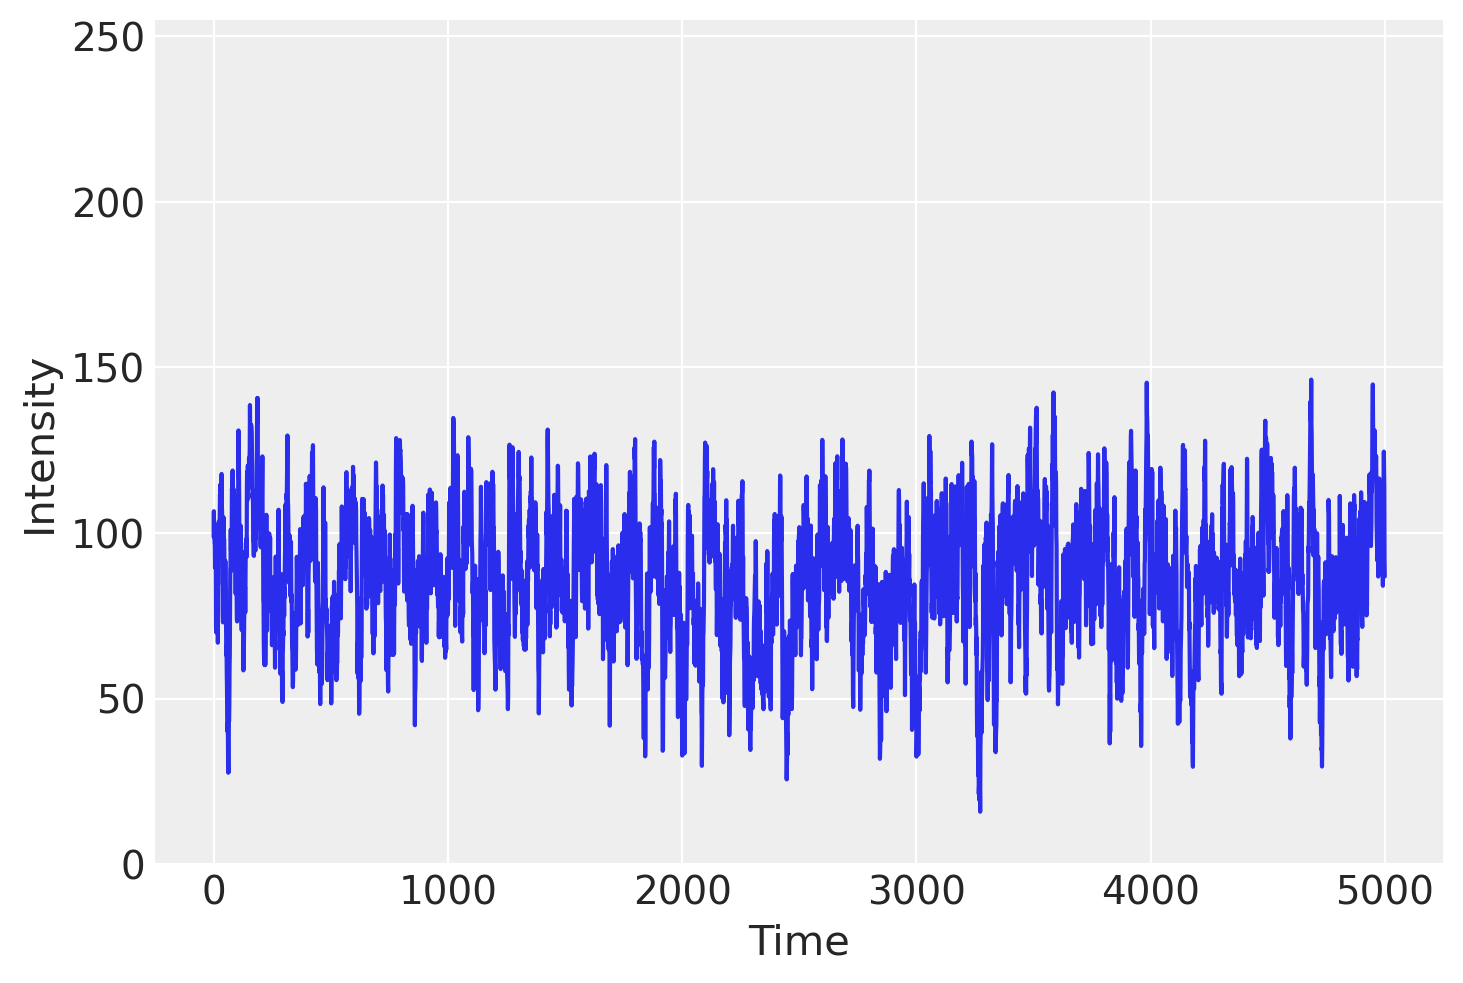

the mean of simulated data is 86.41376114444486
the std of simulated data is 19.560674193791243


In [4]:
simulated_data_single, simulated_t_single=simulate_single_decay_data(number_of_points,tau, quantization, intensity_mean, intensity_std, camera_noise, camera_std)

## Infer decay time from data using the AR(1) model in pymc3

To fit our model AR1 model, we want to extract the following parameters: decay time, which is the $\tau$ above; stationary is the $\phi$, precision is defined as $\frac{1}{\sigma_e^2}$; center is the innovation mean. Our prior for $\tau$ is uniform from 0 to 50, based on the experimental data time scale; for precision, we also use a uniform prior from 0 to 10 times the calculated precision from simulation parameters; for center, it is uniform from the lowest possible intensity to the highest possible intensity.

Thus, the statistical model we use is:
$$ \tau \sim \text{Uniform} (0,50) $$
$$ \text{precision} \sim \text{Uniform} (0, 1) $$
$$ \mu \sim \text{Uniform} (I_{min}, I_{max}) $$
$$ p(X) \sim \text{AR1} (\text{k} = e^{-1/\tau}, \text{tau_e} = \text{precision}, \text{observed} = X-\mu )$$

In [49]:
quantization = 255

### Infer Simulated data

In [6]:
ar1_model_simulated=set_model(simulated_data_single,quantization,'simulated')
trace_single_model_simulated = run_model(ar1_model_simulated)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 18,679
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, noise_std, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 26 seconds.
The acceptance probability does not match the target. It is 0.6775027150241374, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6638534330277996, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6862720359208624, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.66541584911282, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


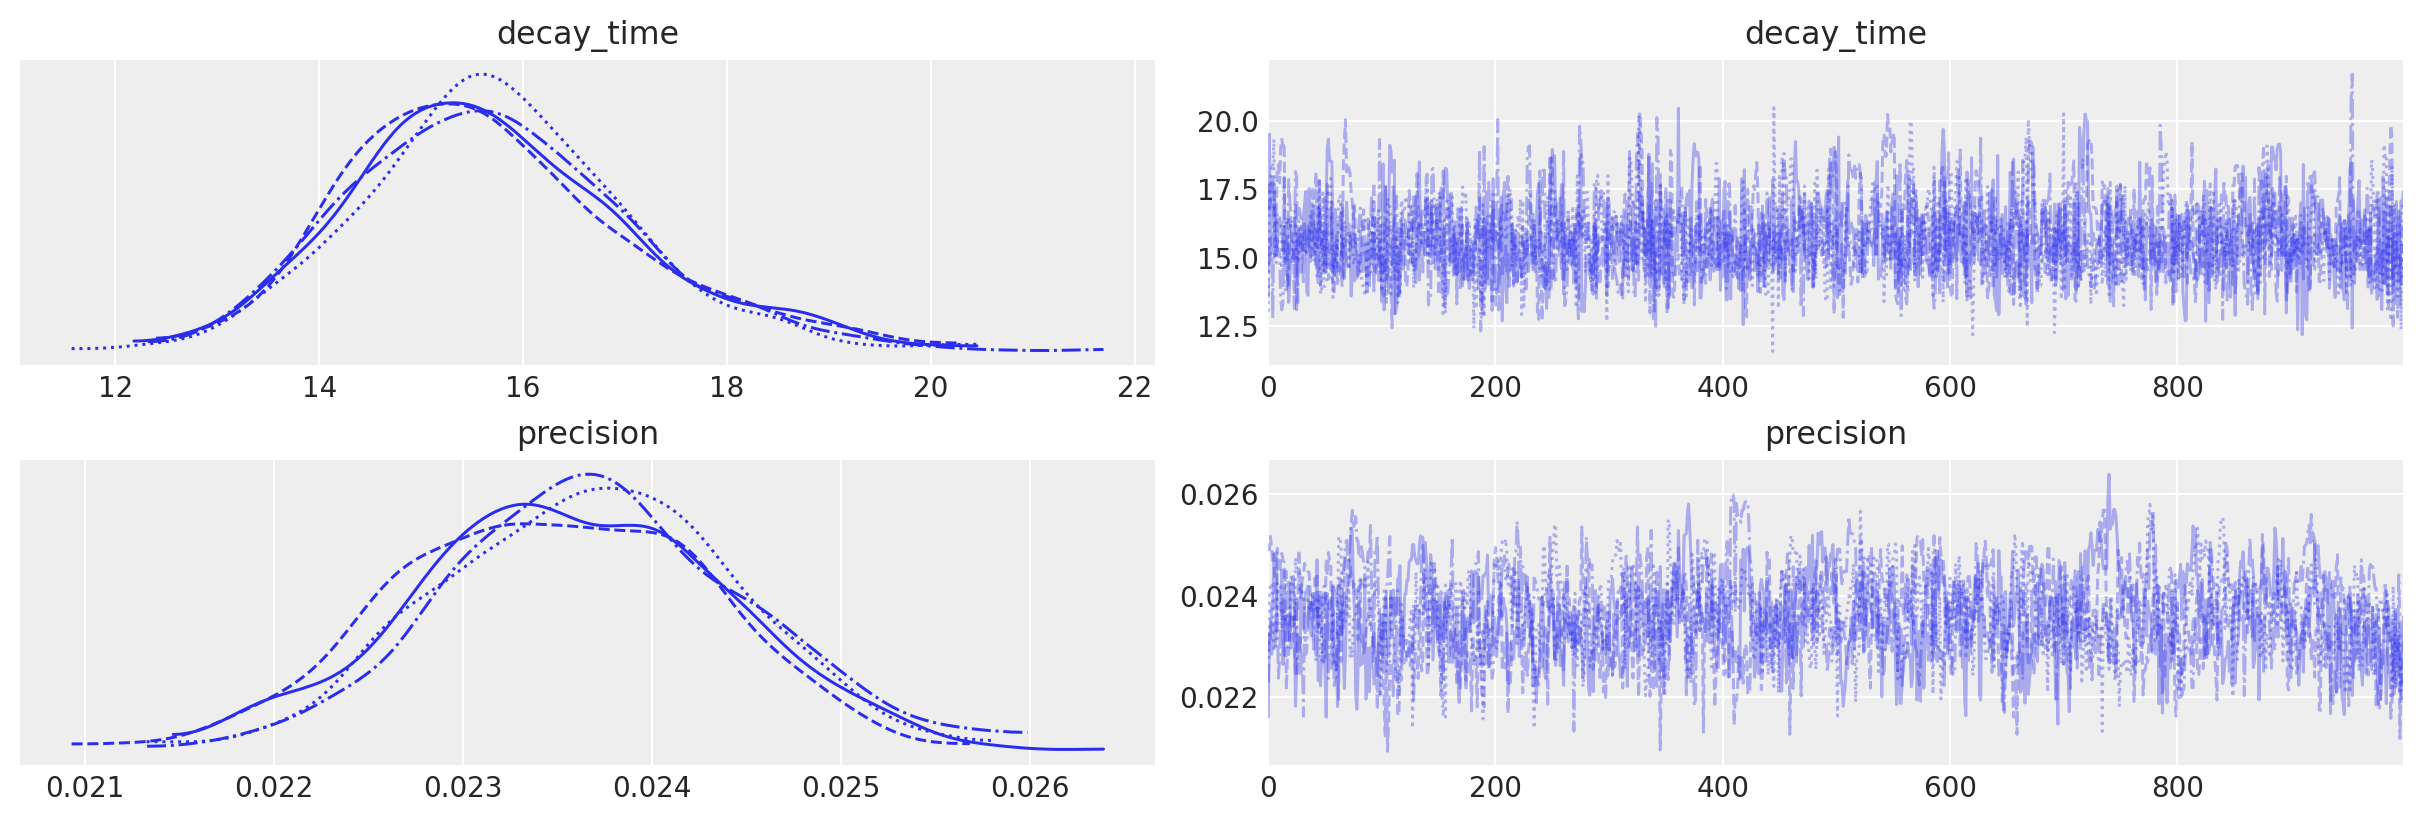

In [7]:
plot_trace(trace_single_model_simulated)

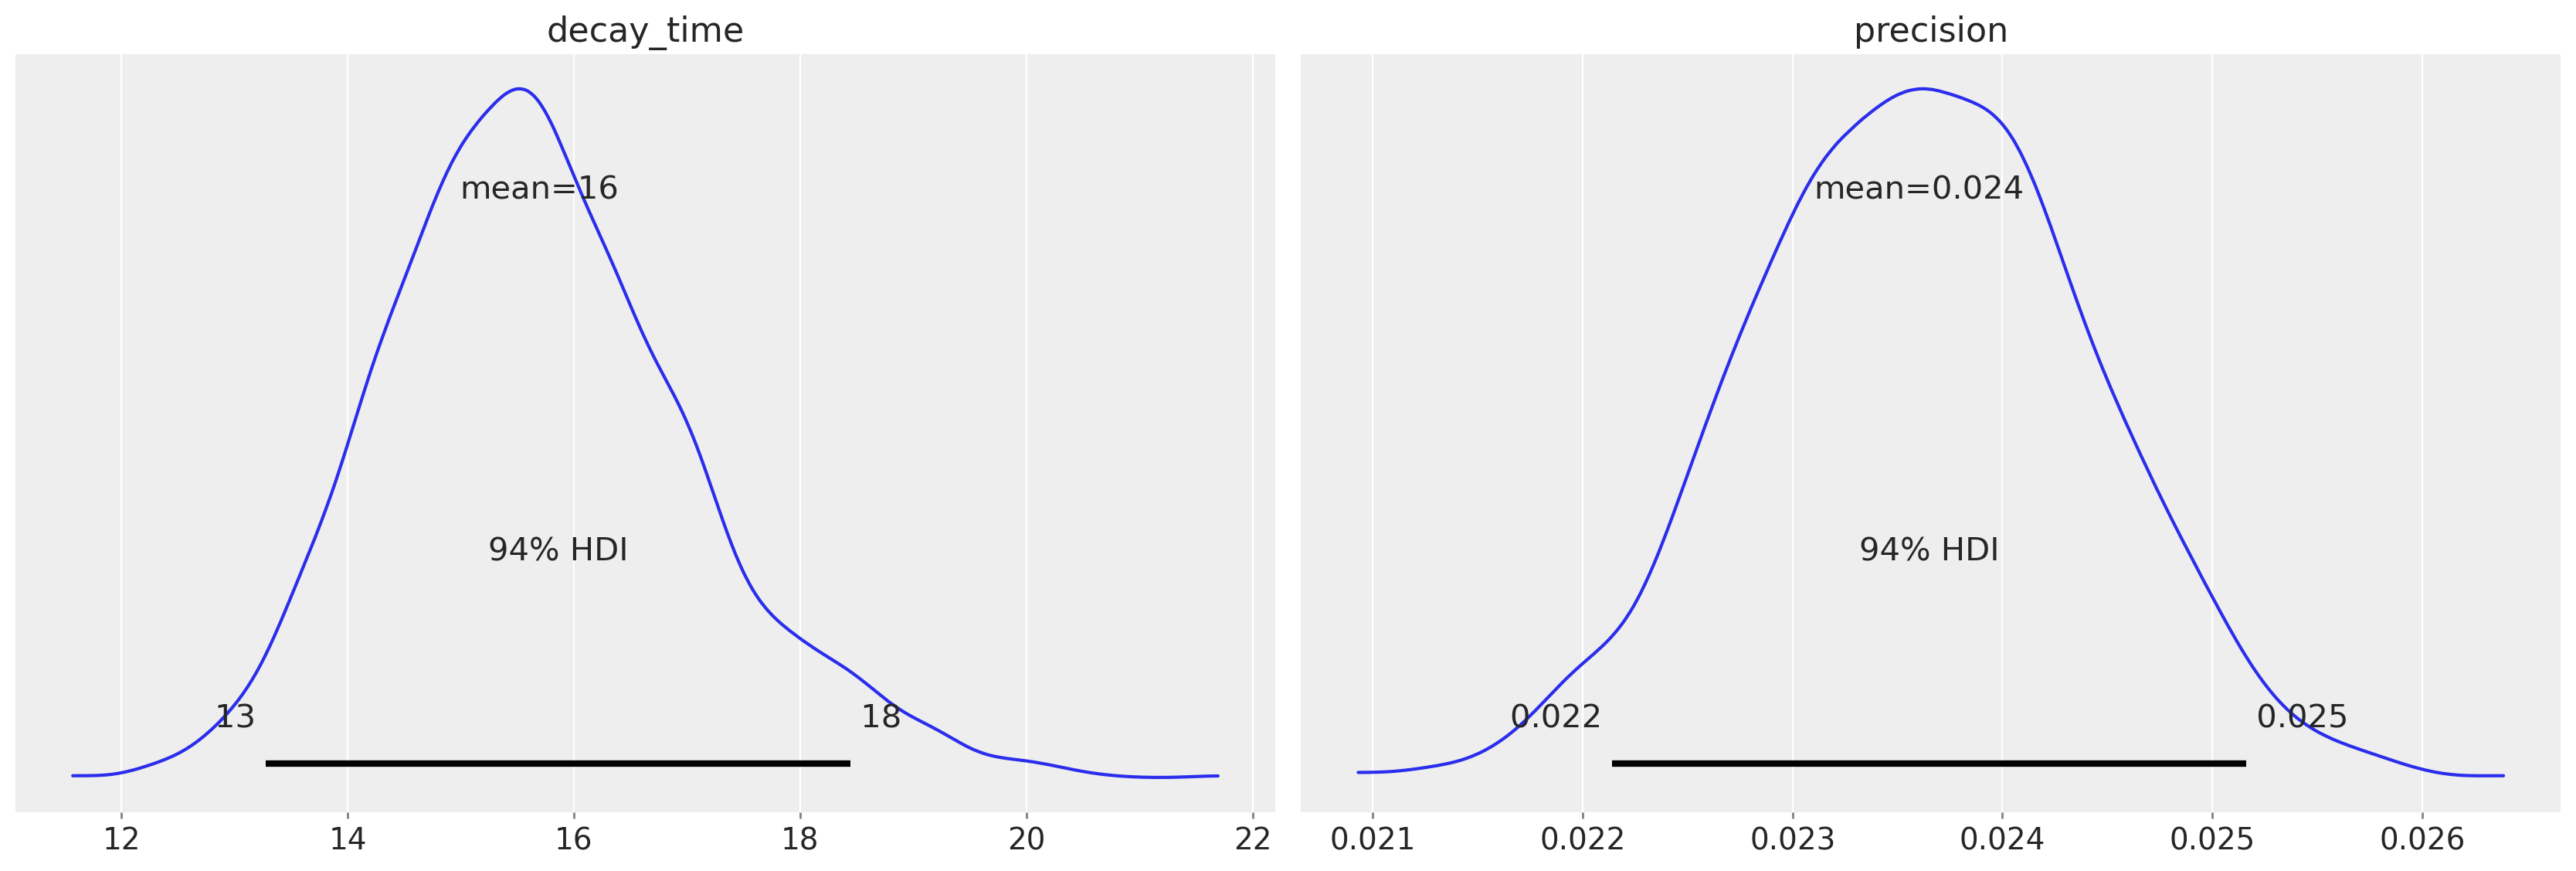

In [8]:
plot_posterior(trace_single_model_simulated)

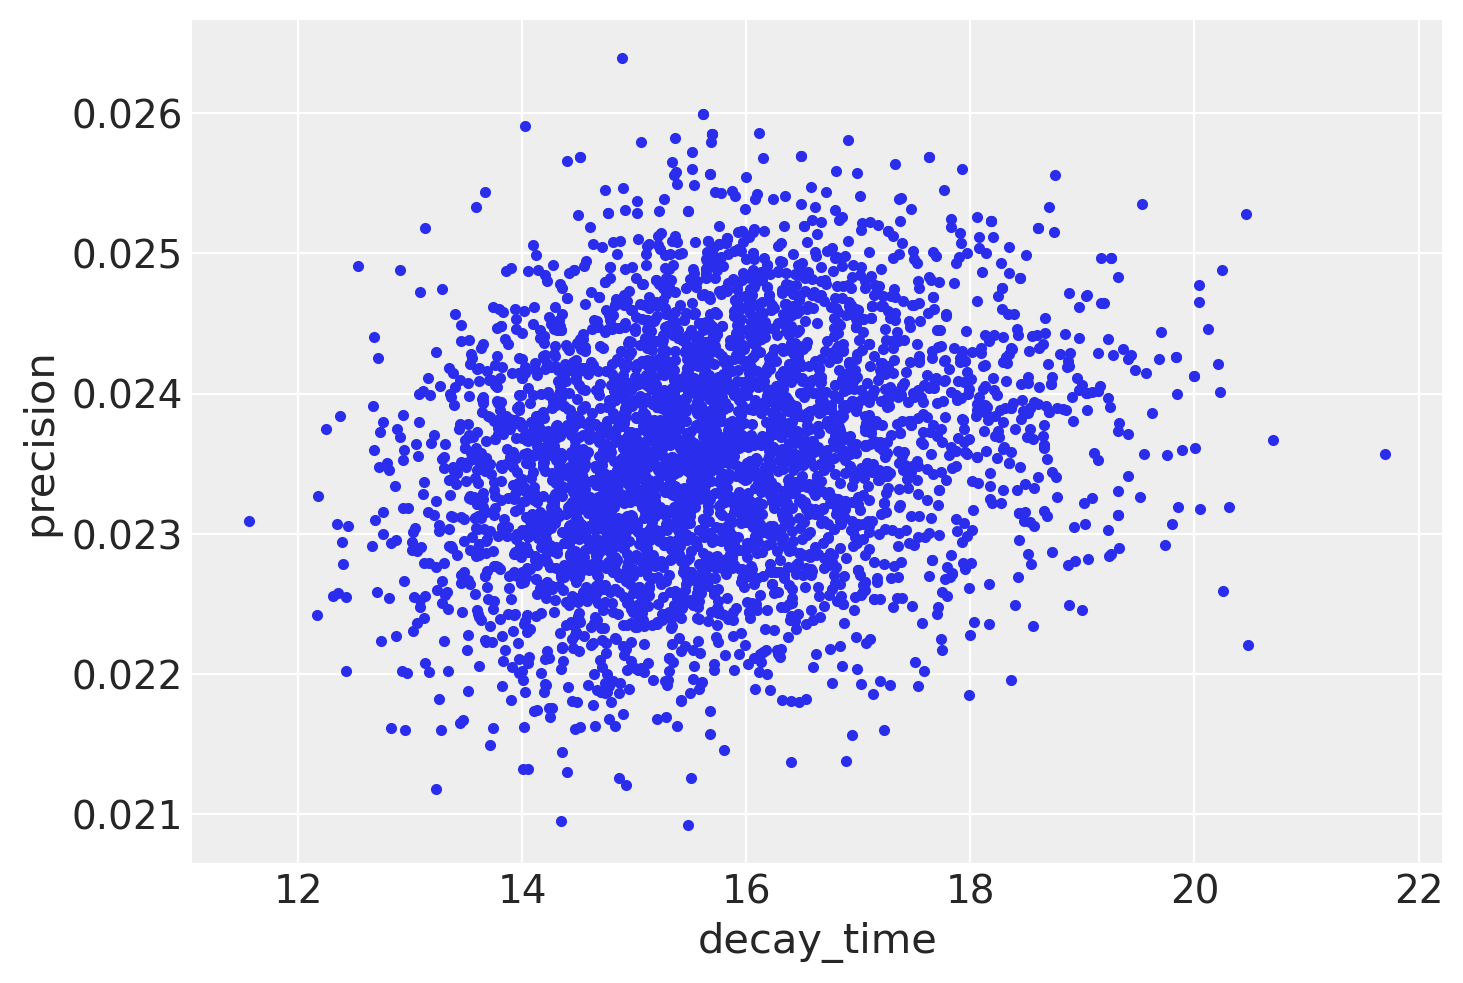

In [9]:
plot_pair(trace_single_model_simulated)

### Infer 2 hour aged sample

For choosing the data point, we pick a random point in the condensate sample, gaussian smooth the intensity at each time point with a 5*5 kernel to reduce the effect from camera noise.

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[100, 100]_2h_intensity.csv


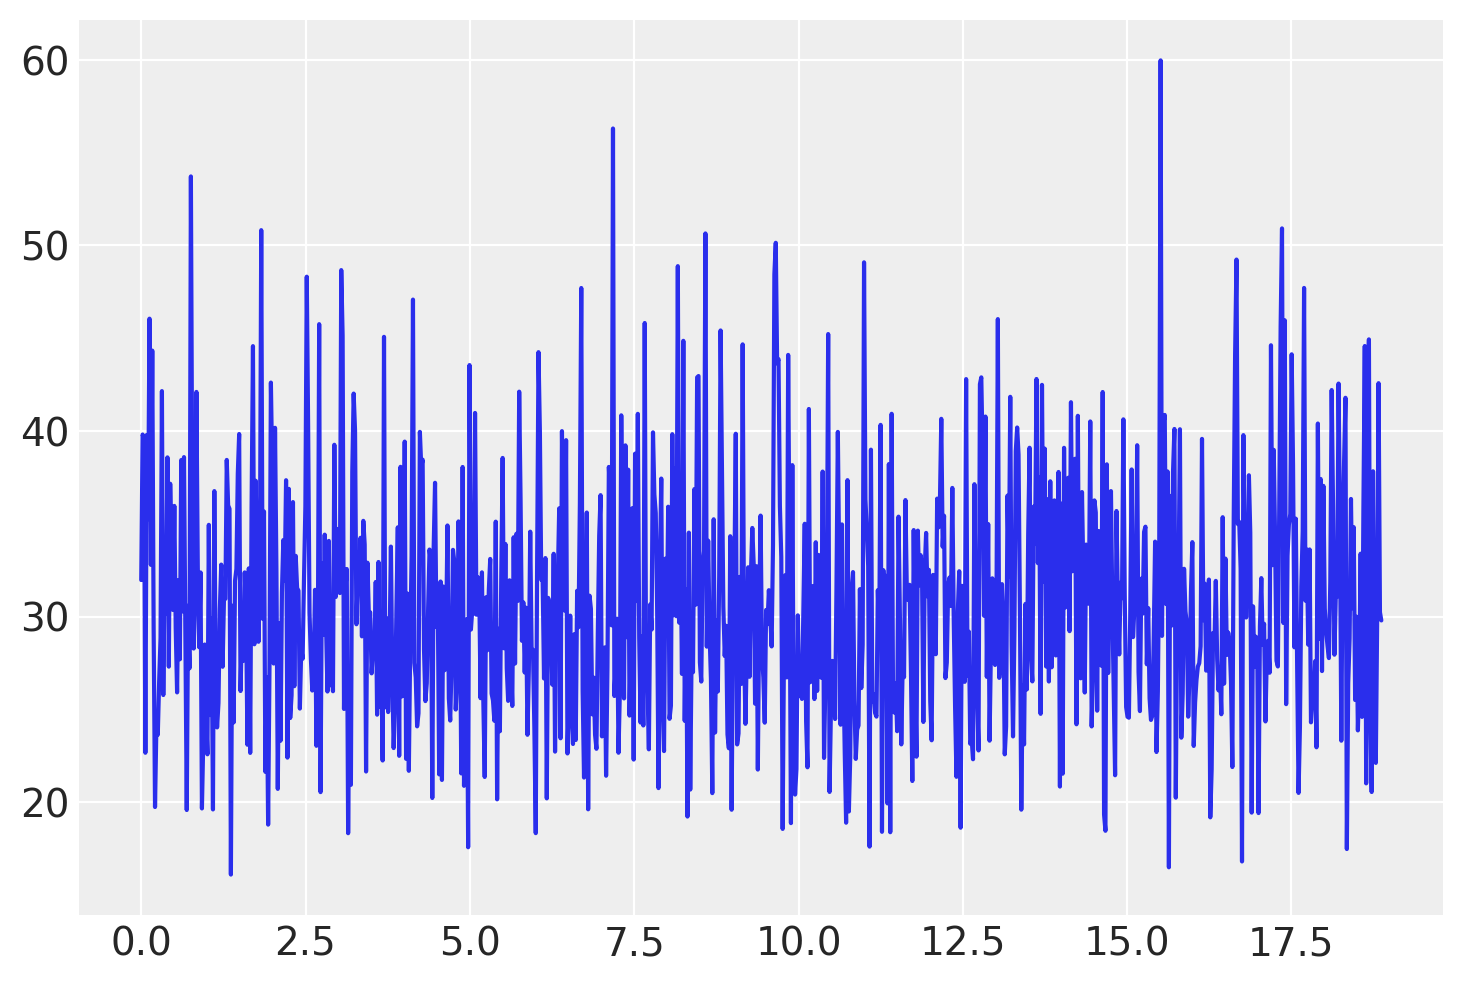

In [10]:
#Load in real data and plot
data_2h = load_data('[100, 100]_2h_intensity.csv',data_dir='condensate_speckle/example_data')

In [11]:
# Sample with pymc3 using the single timescale model
ar1_model_2h=set_model(data_2h['Intensity'],quantization,'2h')
trace_single_model_2h = run_model(ar1_model_2h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 152300
Interrupted at 152,299 [76%]: Average Loss = 2,980.9
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.6507541780862985, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.6596163205149866, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.478790215581102, but should be close to 0.8. Try to increase the number of tuning steps.
There were 80 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


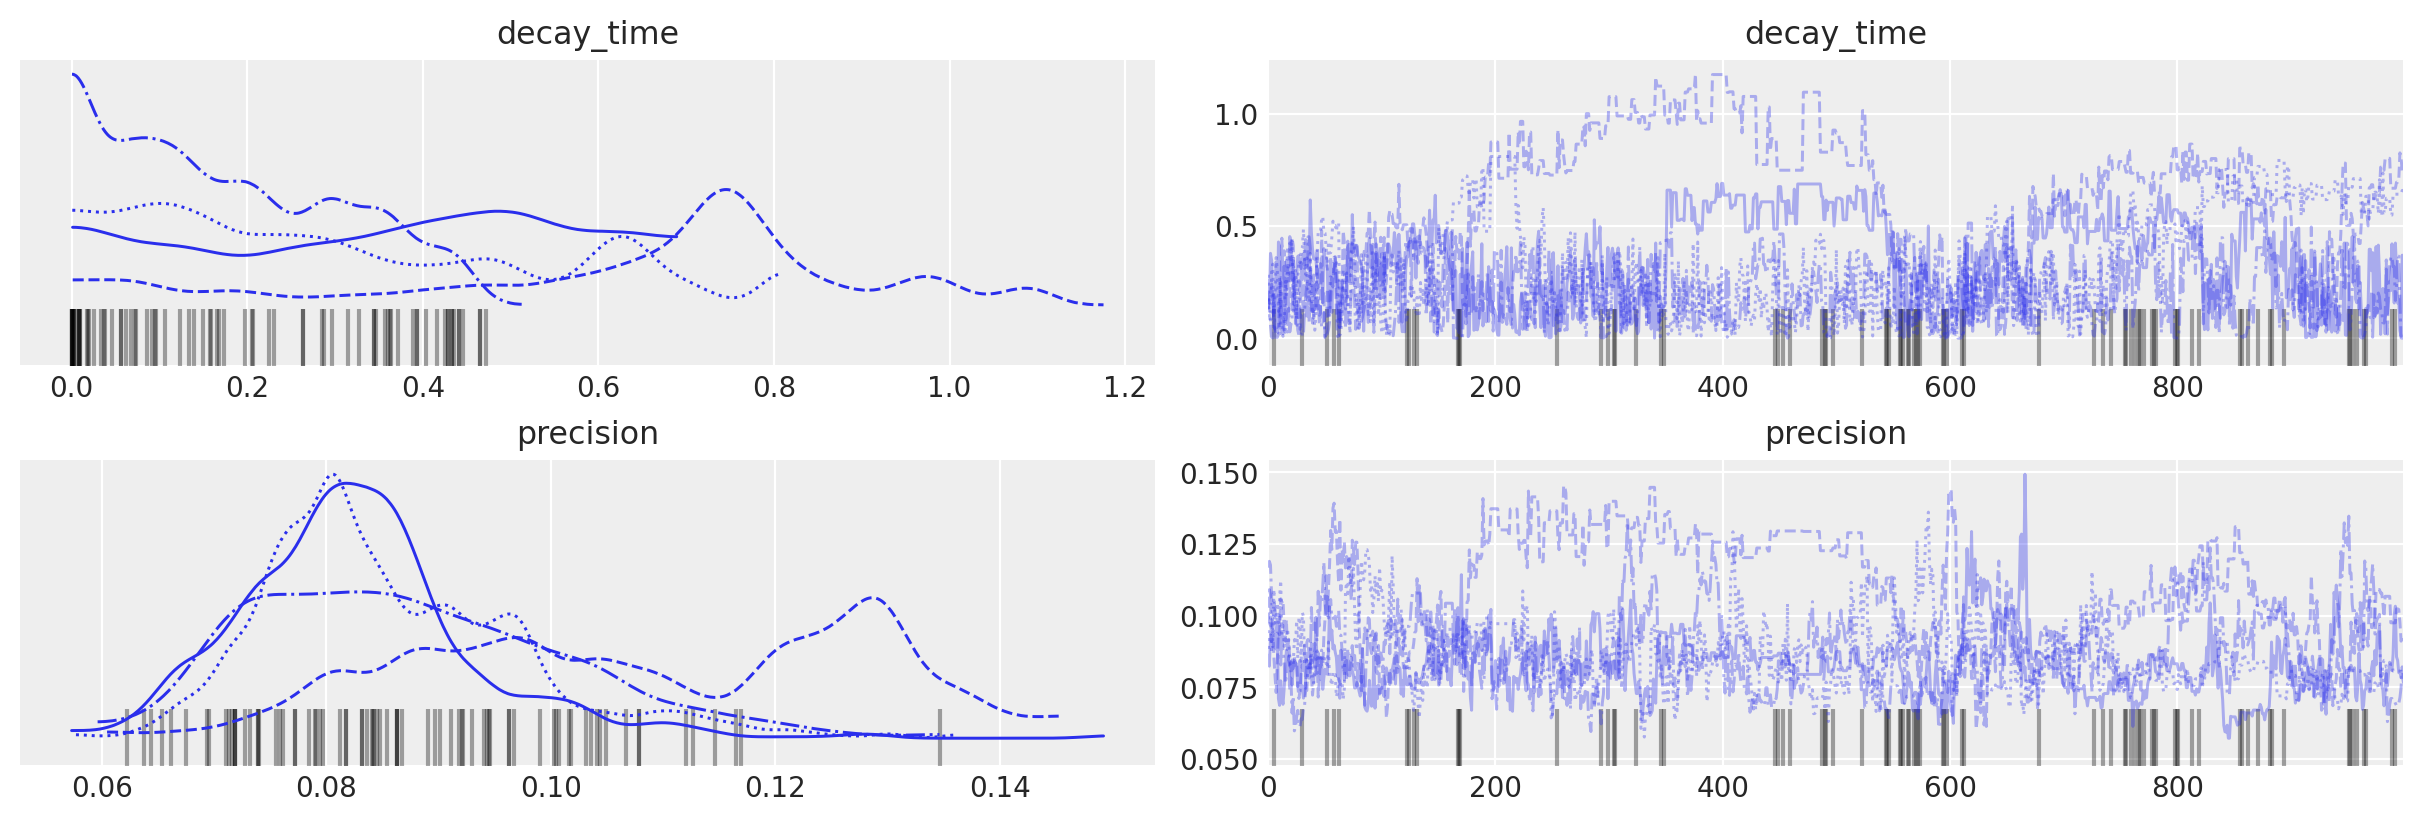

In [12]:
plot_trace(trace_single_model_2h)

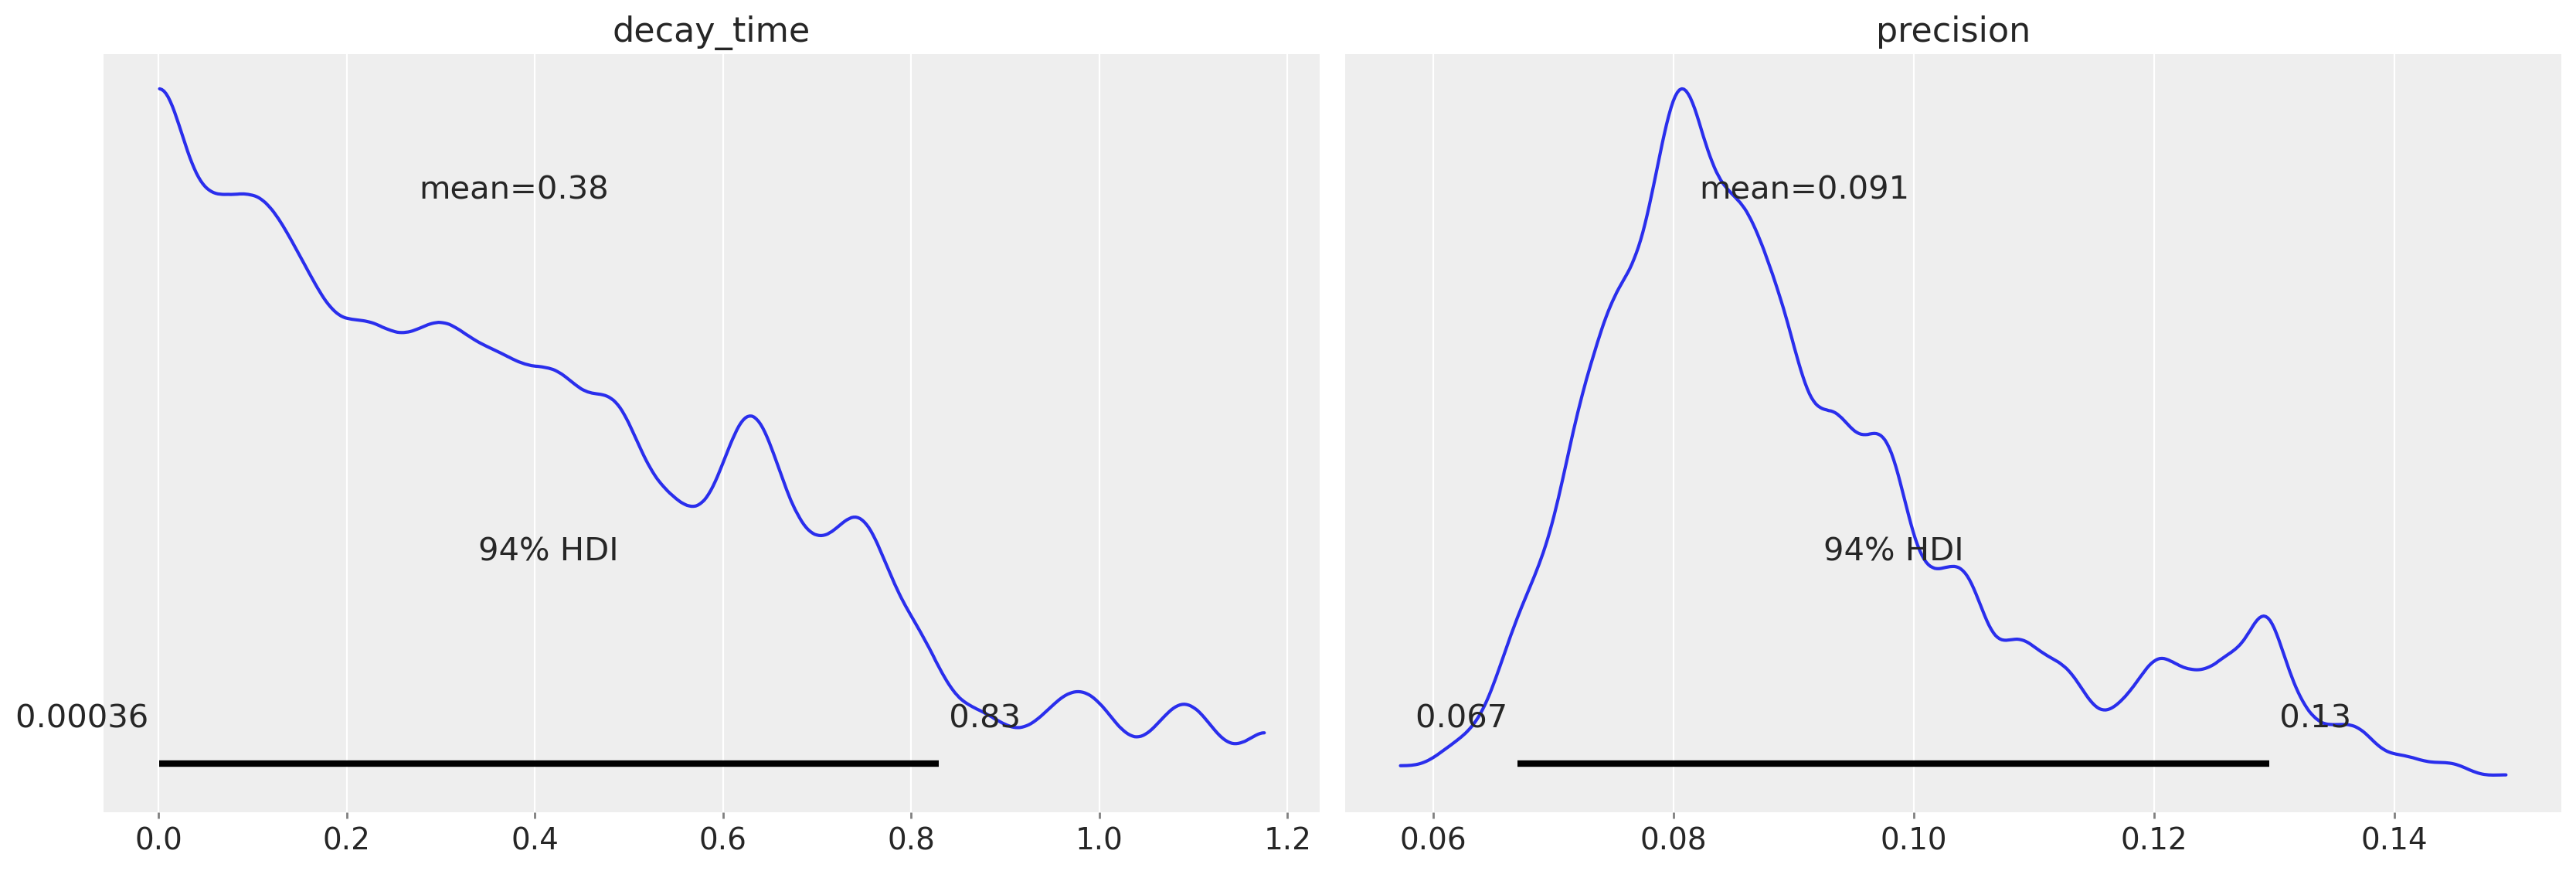

In [13]:
plot_posterior(trace_single_model_2h)

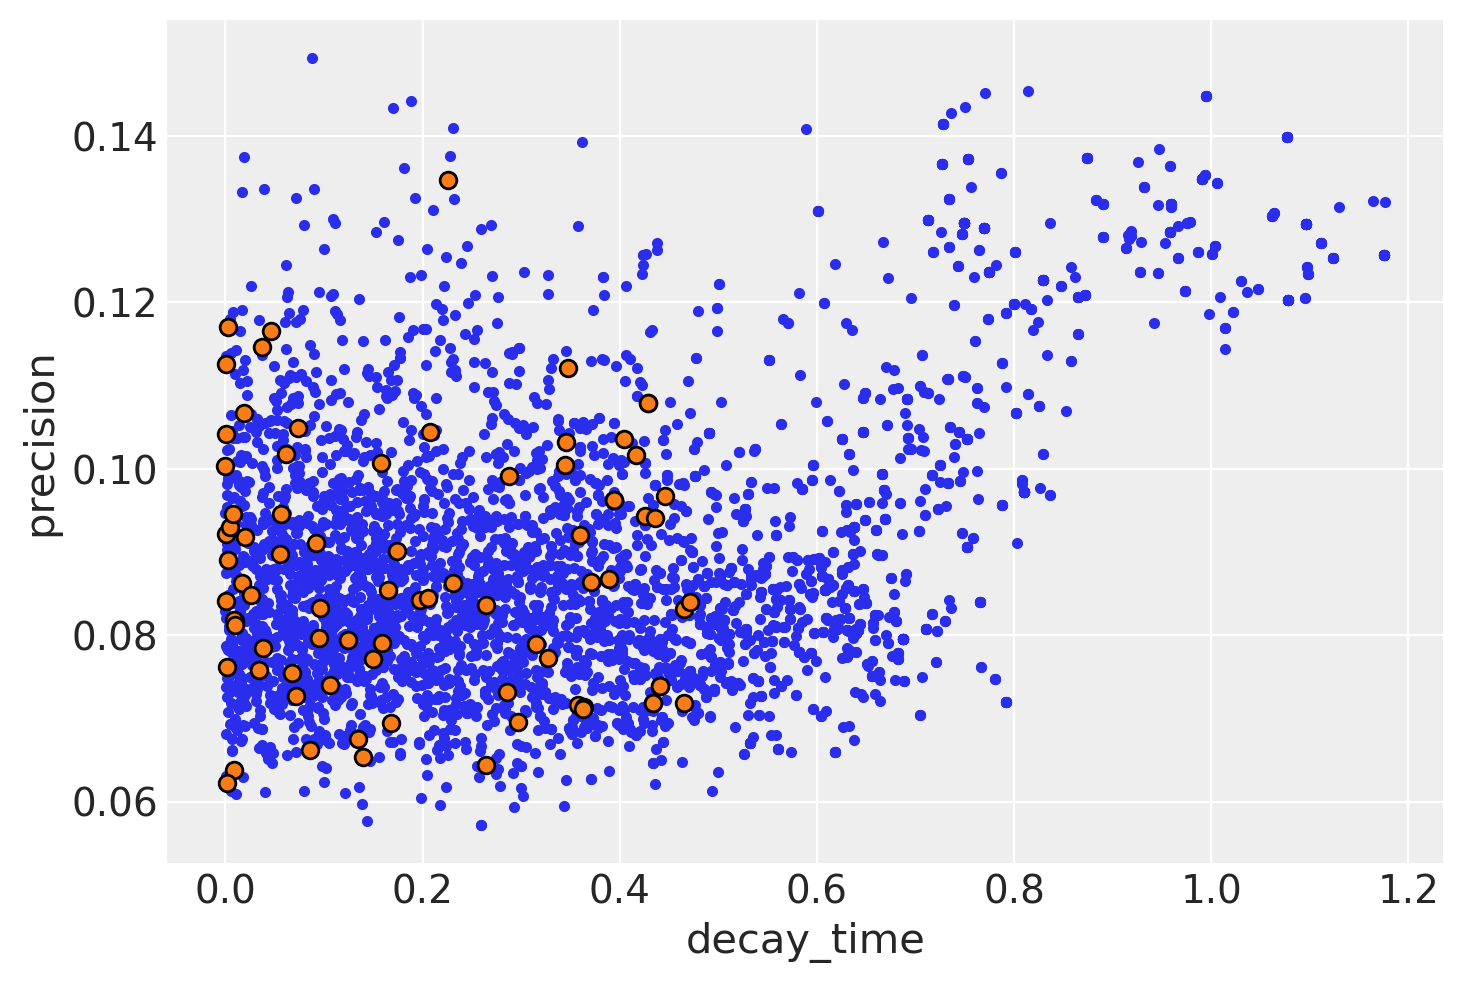

In [14]:
plot_pair(trace_single_model_2h)

### Infer 7 hour aged sample

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[100, 117]_7h_intensity.csv


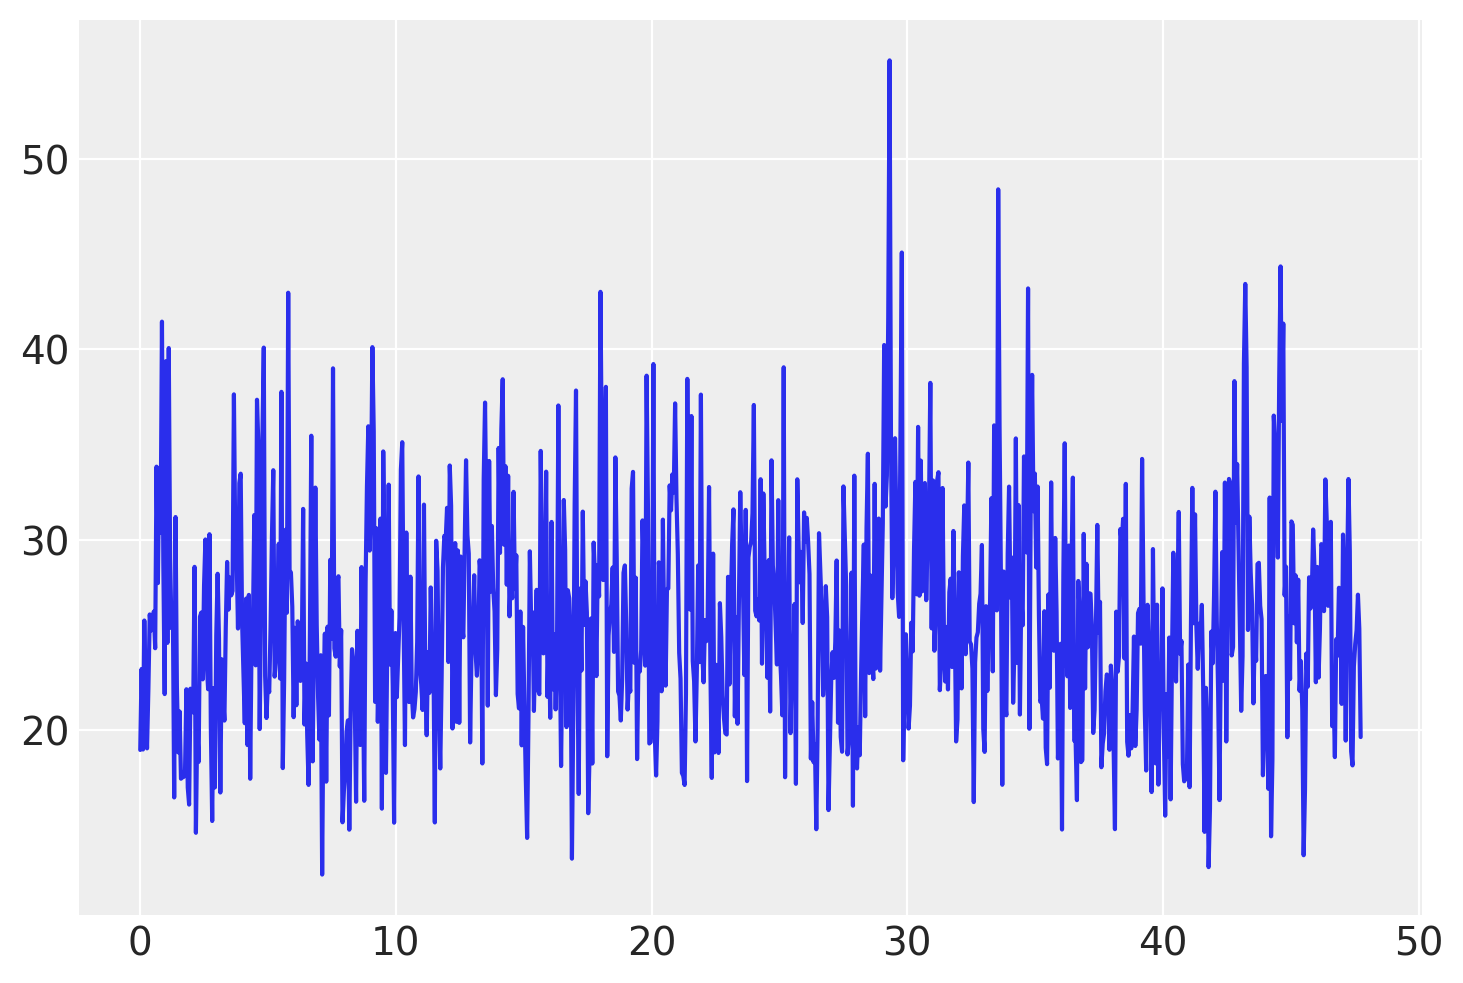

In [15]:
data_7h = load_data('[100, 117]_7h_intensity.csv',data_dir='condensate_speckle/example_data')

In [16]:
ar1_model_7h=set_model(data_7h['Intensity'],quantization,'7h')
trace_single_model_7h= run_model(ar1_model_7h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 106700
Interrupted at 106,699 [53%]: Average Loss = 3,053.7
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, noise_std, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


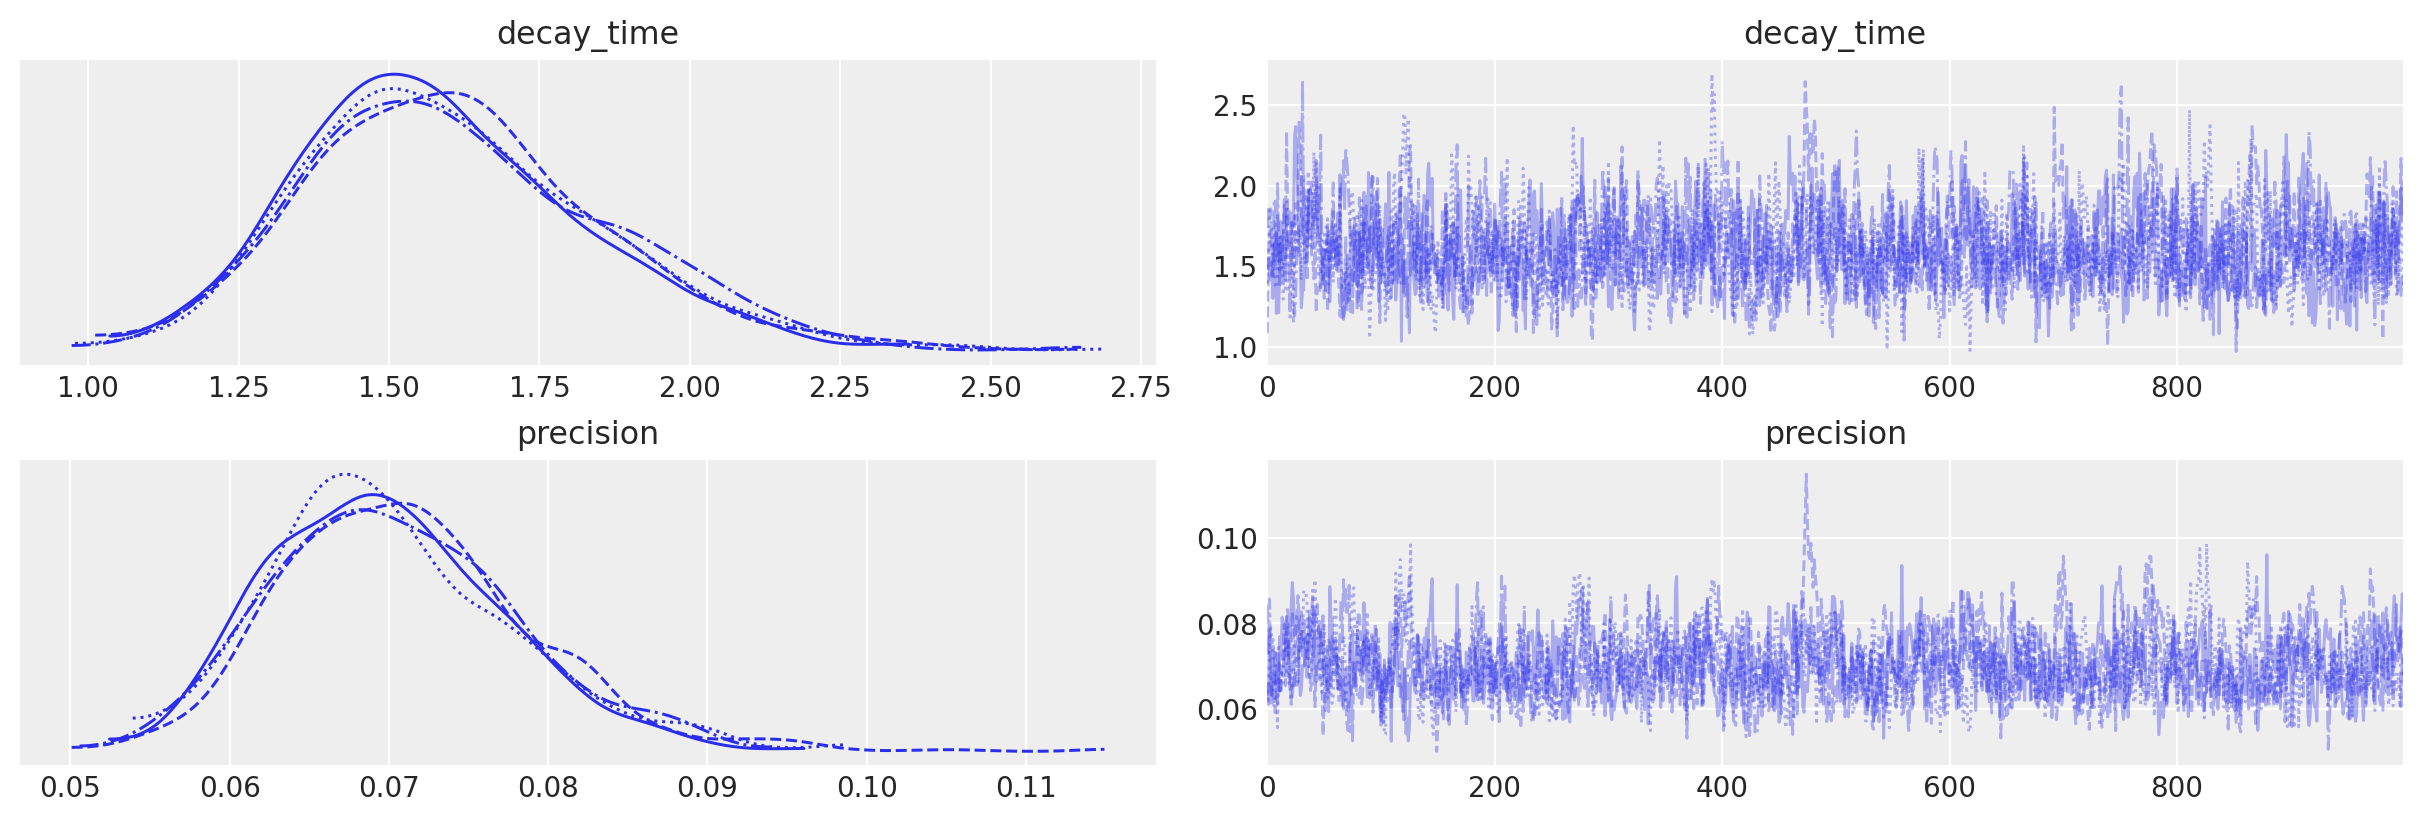

In [17]:
plot_trace(trace_single_model_7h)

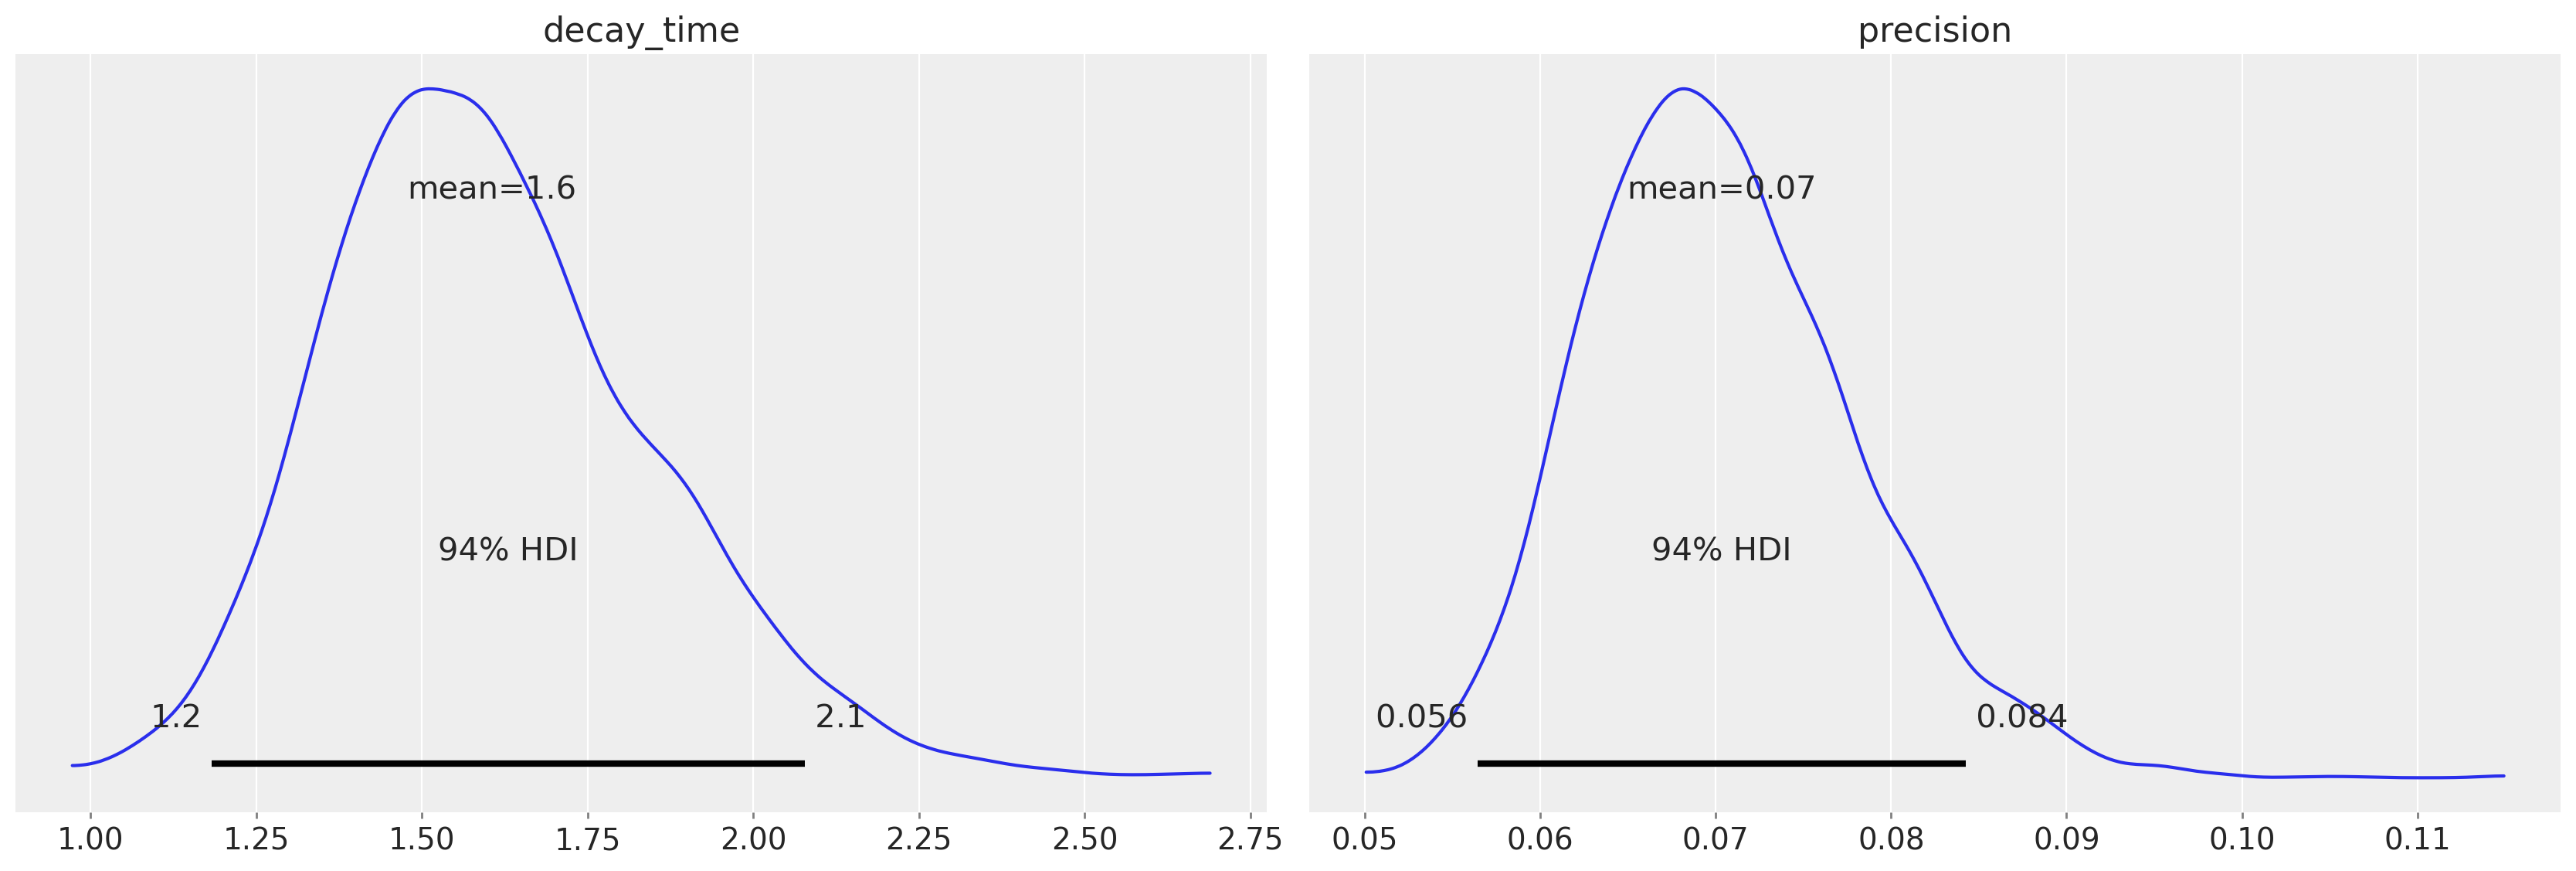

In [18]:
plot_posterior(trace_single_model_7h)

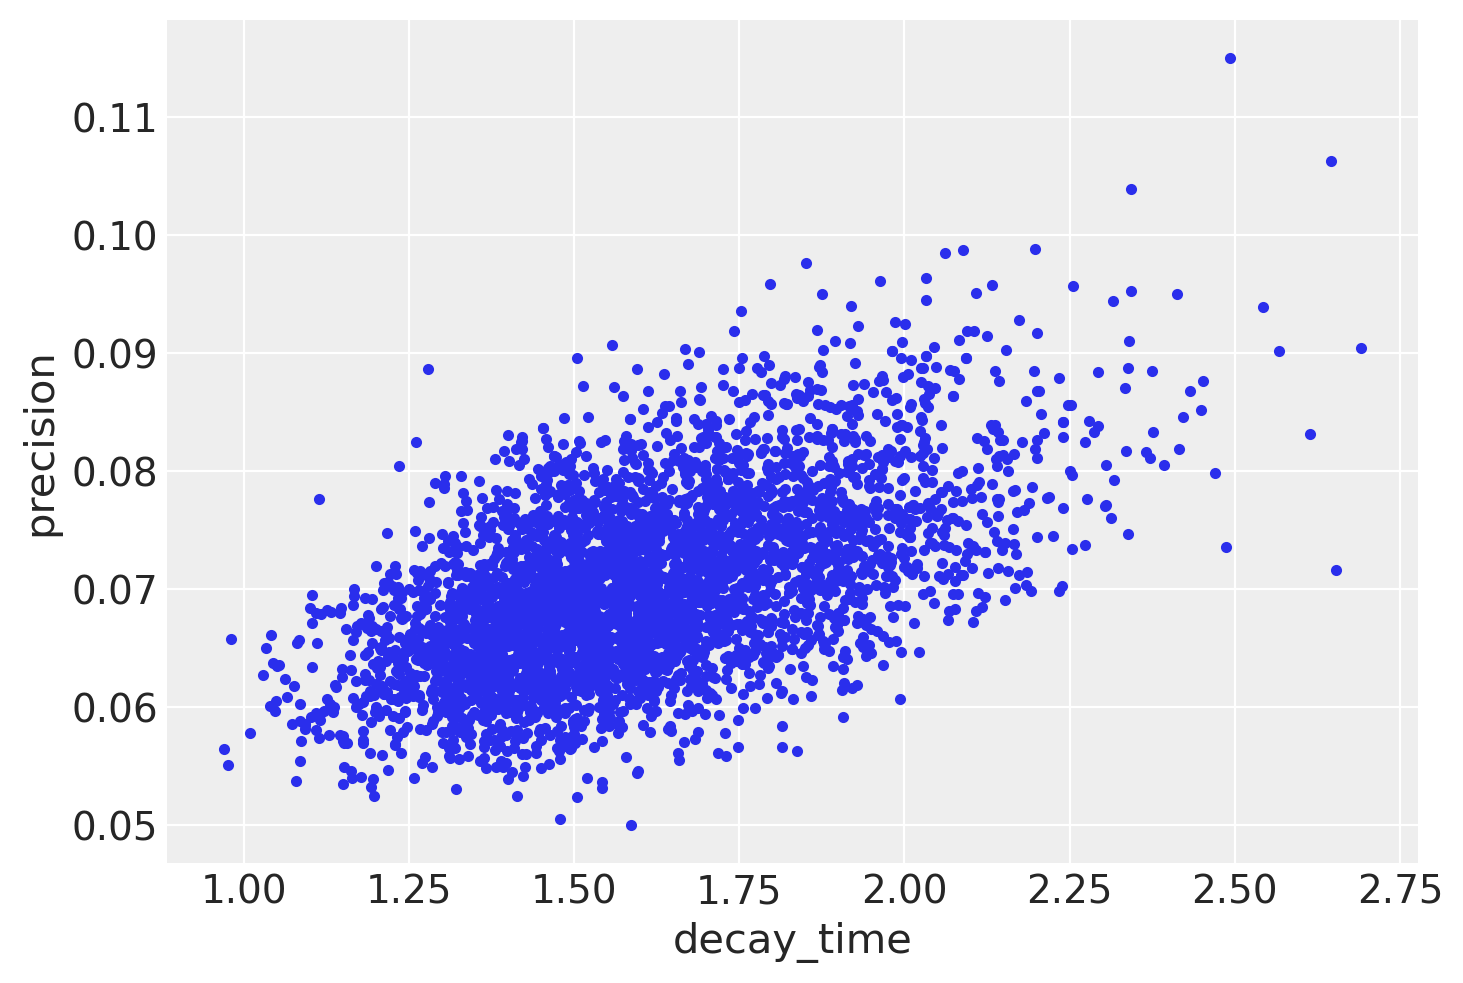

In [19]:
plot_pair(trace_single_model_7h)

### Infer 24 hour aged sample

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/example_data/[120, 145]_intensity.csv


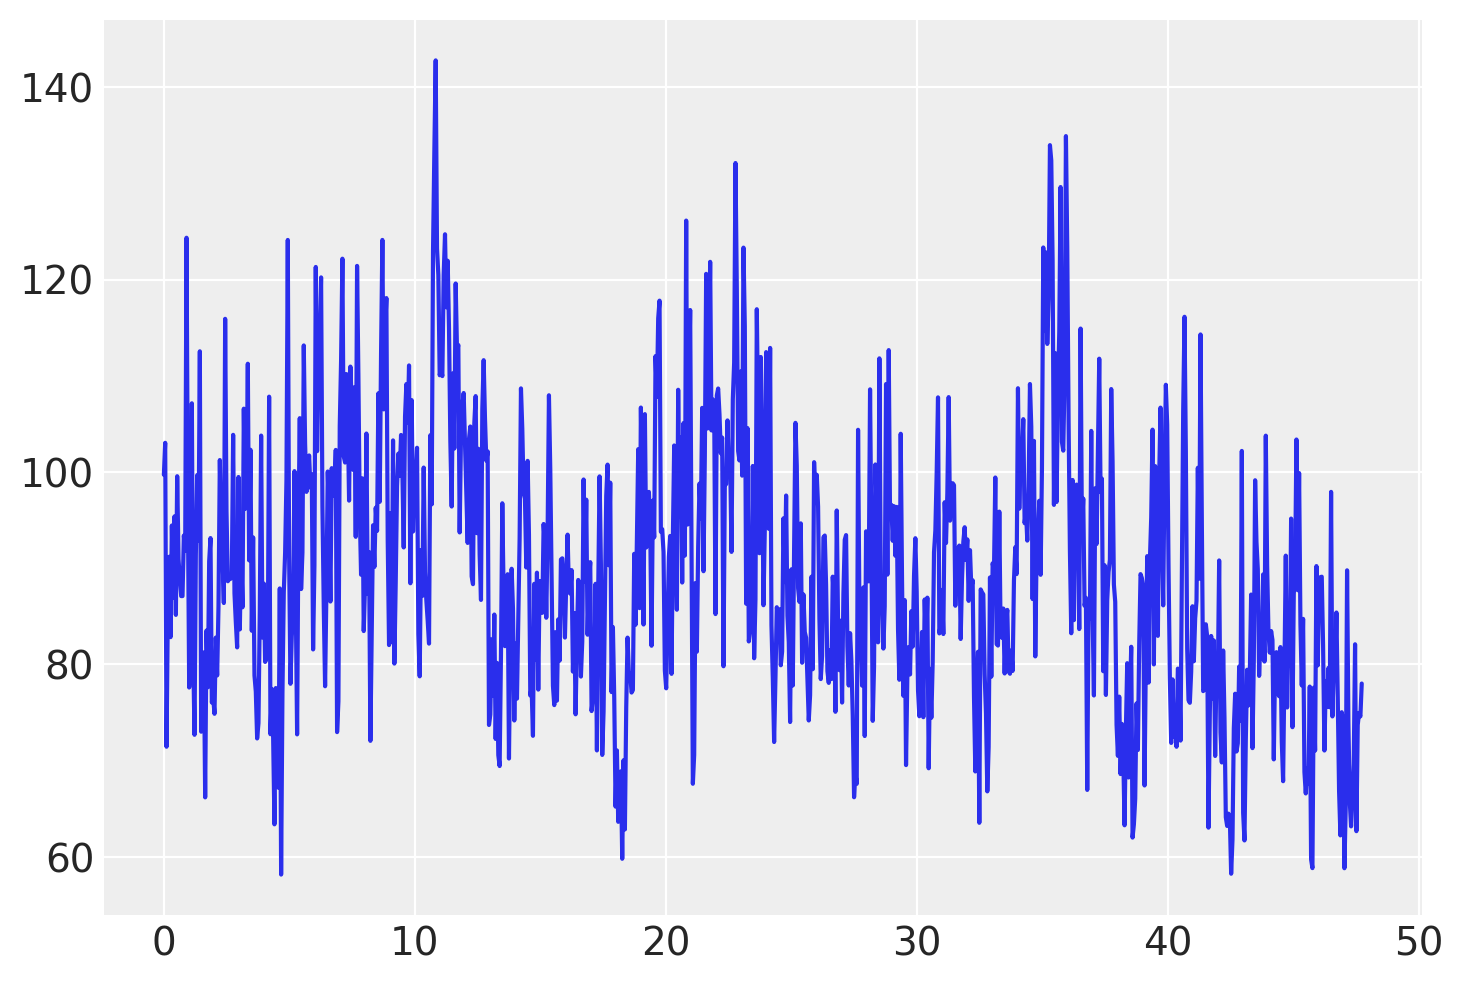

In [50]:
data_24h = load_data('[120, 145]_intensity.csv',data_dir='condensate_speckle/example_data')

In [21]:
ar1_model_24h=set_model(data_24h['Intensity'],quantization,'24h')
trace_single_model_24h= run_model(ar1_model_24h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,461.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y, precision, noise_std, decay_time]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 20 seconds.
The number of effective samples is smaller than 25% for some parameters.


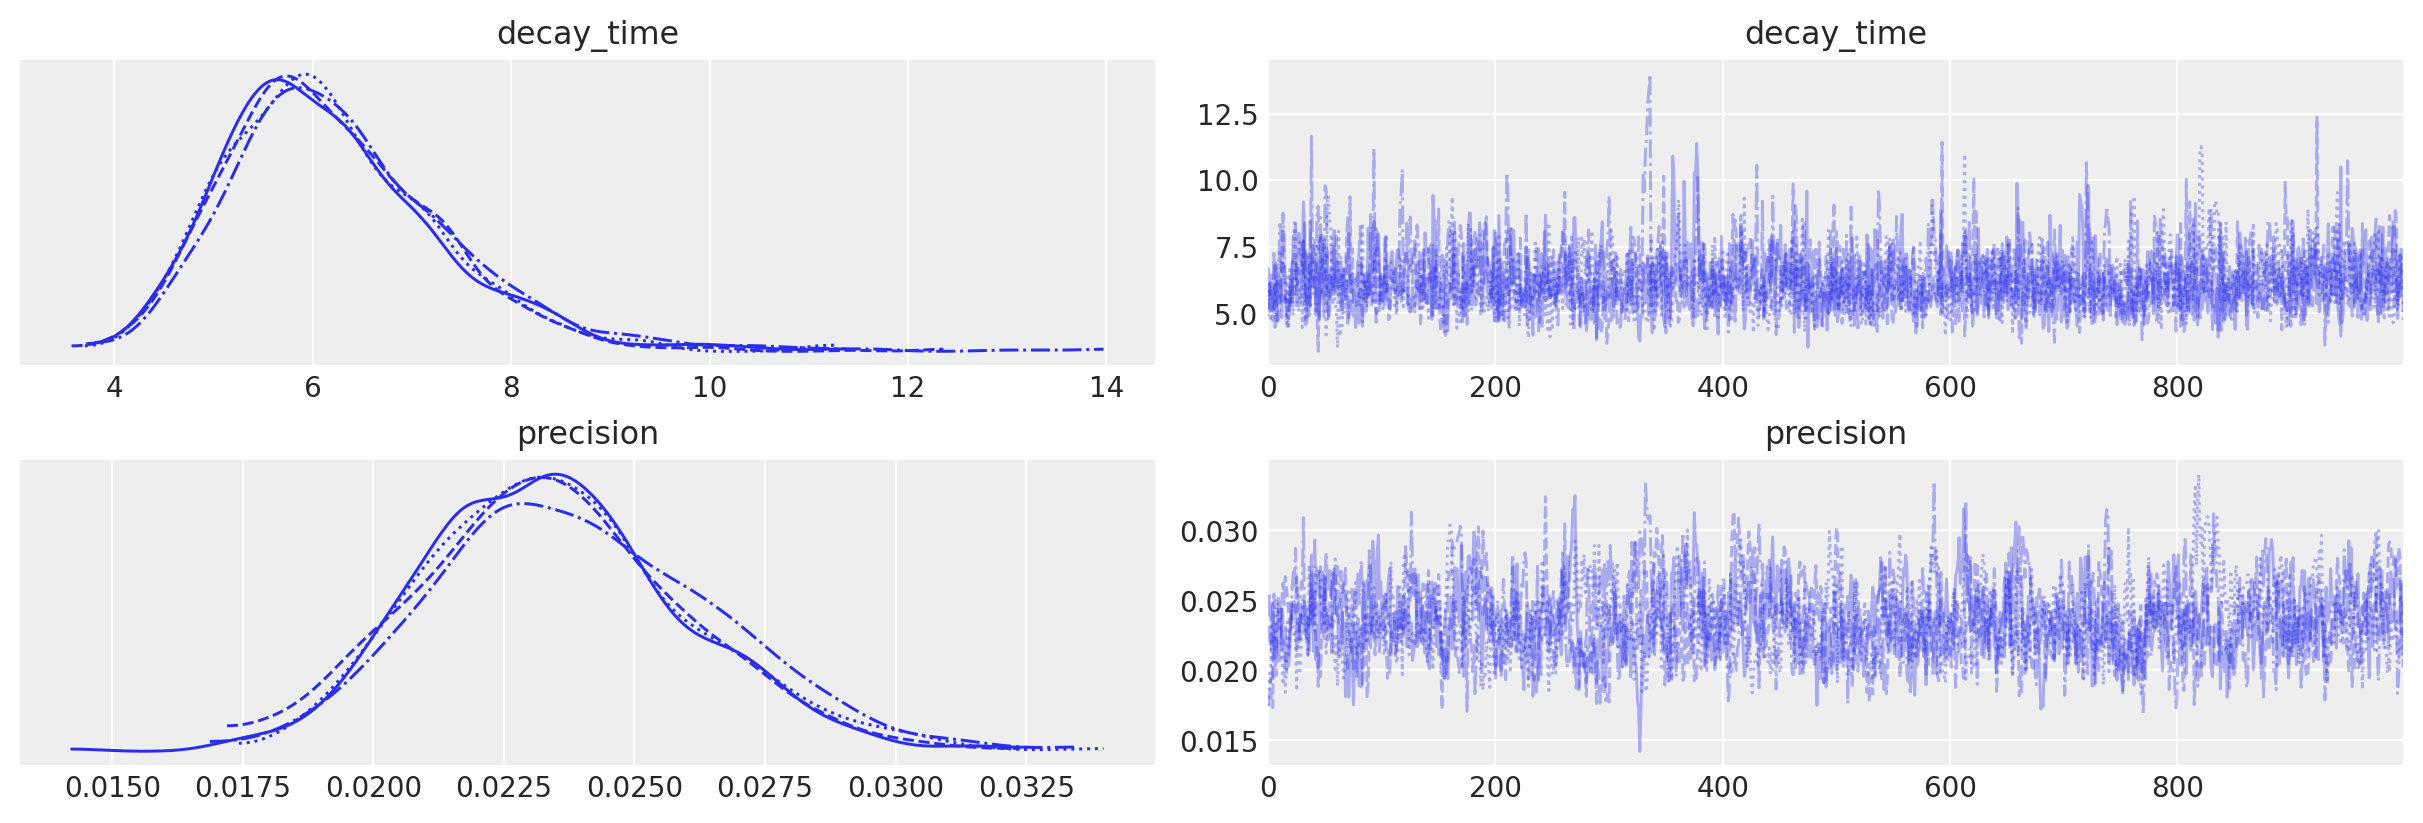

In [22]:
plot_trace(trace_single_model_24h)

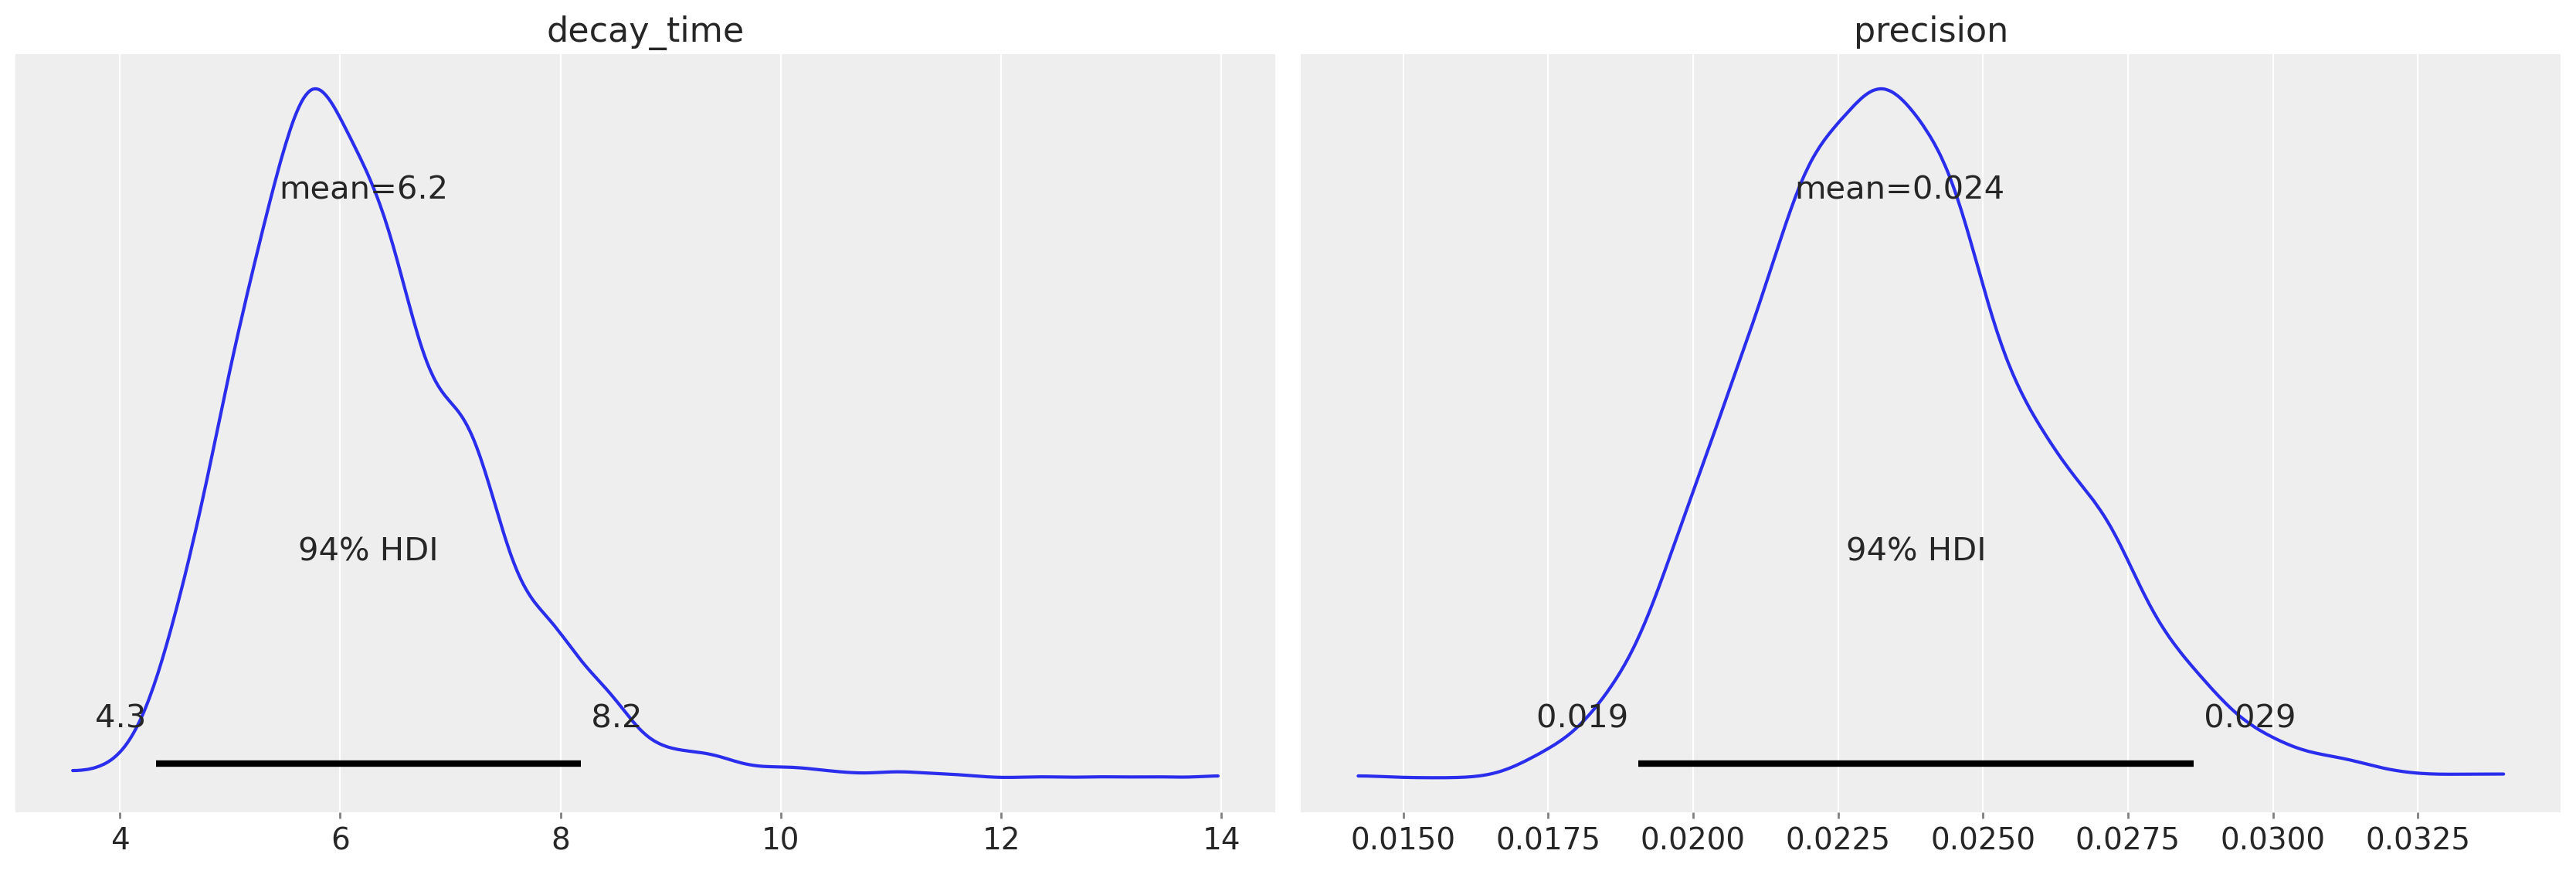

In [23]:
plot_posterior(trace_single_model_24h)

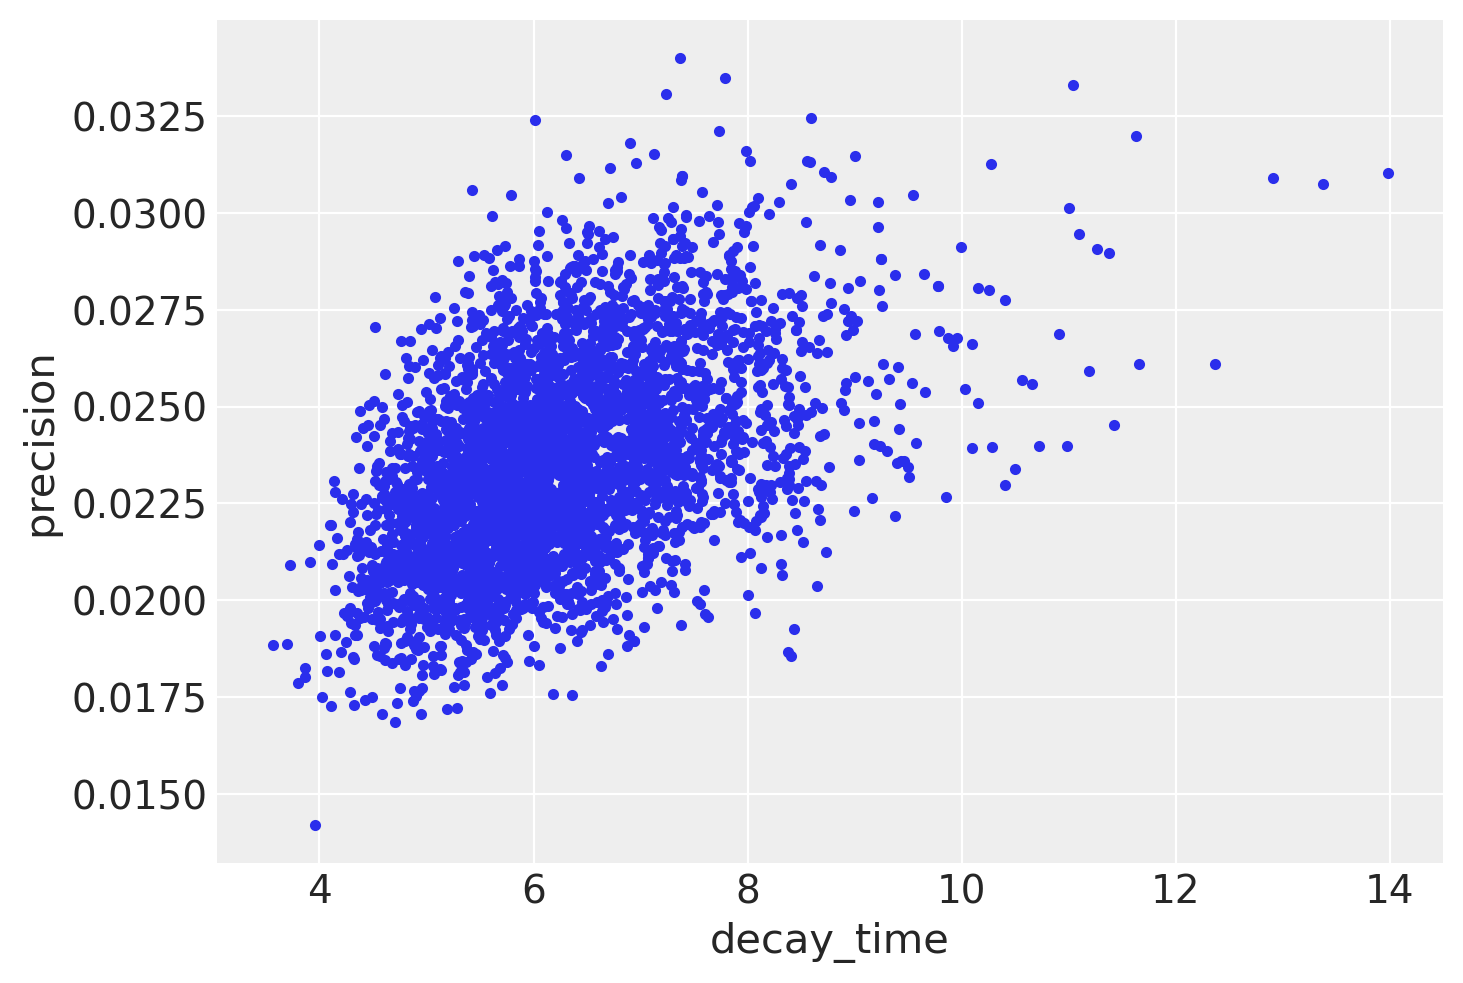

In [24]:
plot_pair(trace_single_model_24h)

# "Can do" Goal - 2 timescale decay

## simulate data

In [ ]:
number_of_points=1000
tau_1=3
tau_2=30
relative_var=0.5
quantization=255
intensity_mean=80
intensity_std=40
camera_noise=8
camera_std=3

In [ ]:
simulated_data_double, simulated_t_double=simulate_double_decay_data(number_of_points,tau_1,tau_2, relative_var,quantization, intensity_mean, intensity_std, camera_noise, camera_std)

## Infer decay time from data using the AR(1)+AR(1) model in pymc3

### Infer simulated data

In [30]:
ar1_multi_model_double=set_single_precision_model(simulated_data_double, quantization)
trace_multi_model_double = run_model(ar1_multi_model_double)

/Users/wenyun/Documents/GitHub/Condensate_speckles/condensate_speckle/inference/model.py:82: RuntimeWarning: invalid value encountered in sqrt
  camera_noise_std_mean = np.sqrt(data)


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'decay_time_1_interval__': array(0.), 'decay_time_split_interval__': array(0.), 'precision_interval__': array(0.), 'y_1': array([0., 0., 0., ..., 0., 0., 0.]), 'y_2': array([0., 0., 0., ..., 0., 0., 0.])}

Initial evaluation results:
decay_time_1_interval__         -1.39
decay_time_split_interval__     -1.39
precision_interval__            -1.39
y_1                           -573.51
y_2                           -573.86
likelihood                       -inf
Name: Log-probability of test_point, dtype: float64

In [ ]:
plot_trace(trace_multi_model_double, n_time_scale = 2)

In [ ]:
plot_posterior(trace_multi_model_double, n_time_scale = 2)

In [ ]:
plot_pair(trace_single_model_double)

### From the result of single AR(1) model, the 2 hour aged sample has a decay time constant less than 1 time frame. Indicating it as a liquid state, so we do not think the two time scale model fits this condition.

### Infer 7h aged data

In [31]:
ar1_multi_model_7h=set_single_precision_model(data_7h['Intensity'], quantization)
trace_multi_model_7h = run_model(ar1_multi_model_7h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 158000
Interrupted at 157,999 [78%]: Average Loss = 3,008.8
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, precision, decay_time_split, decay_time_1]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 122 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


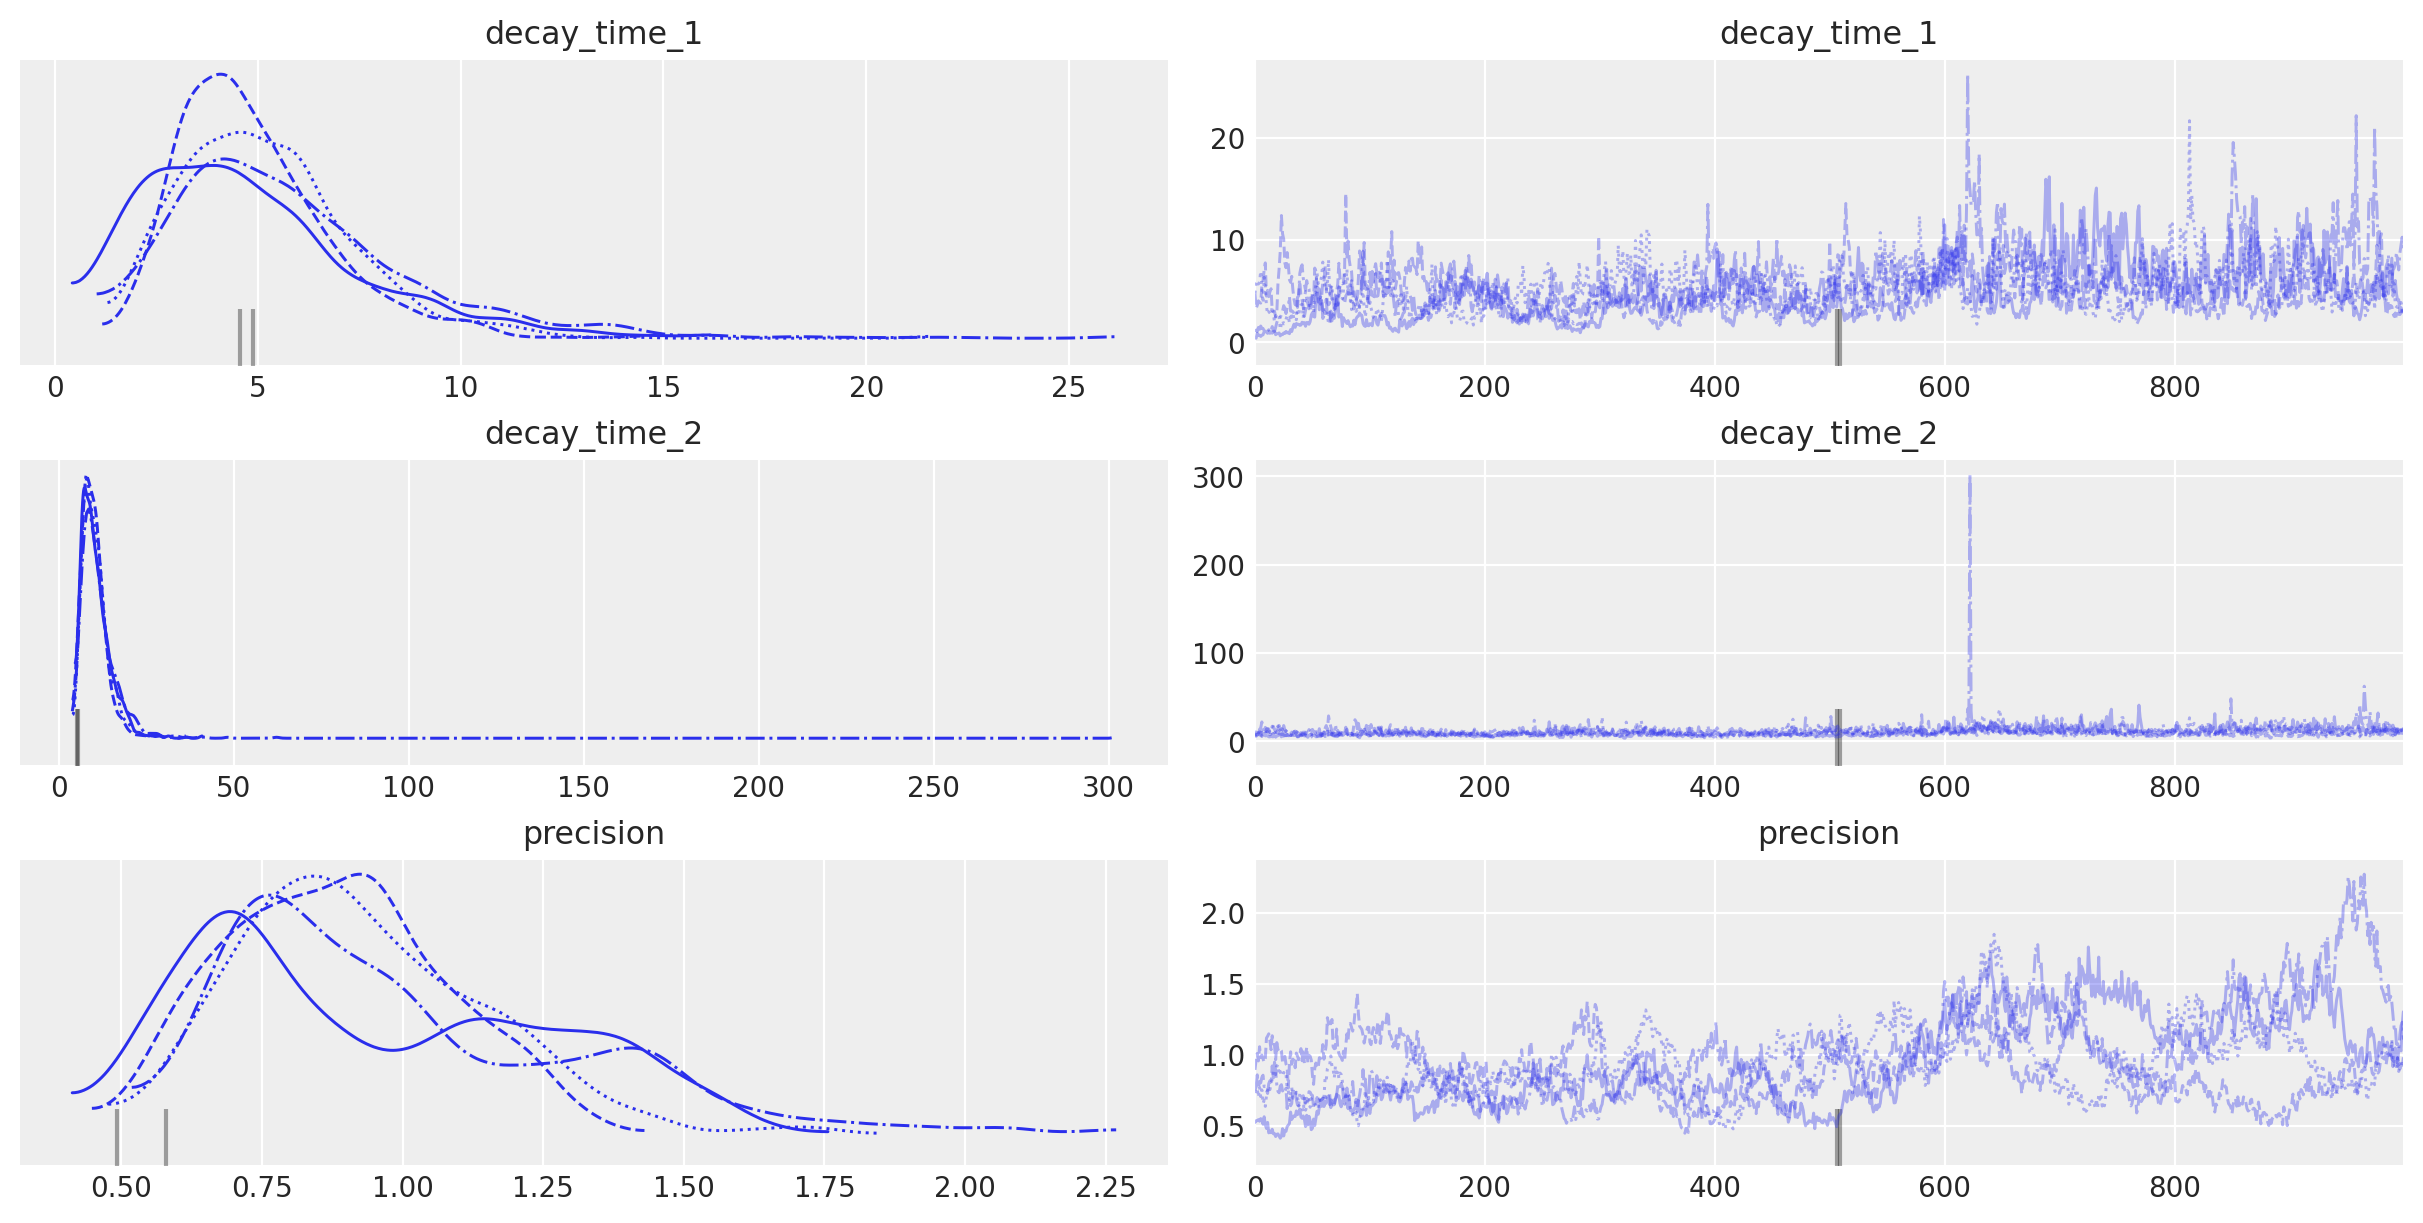

In [32]:
plot_trace(trace_multi_model_7h, n_time_scale = 2)

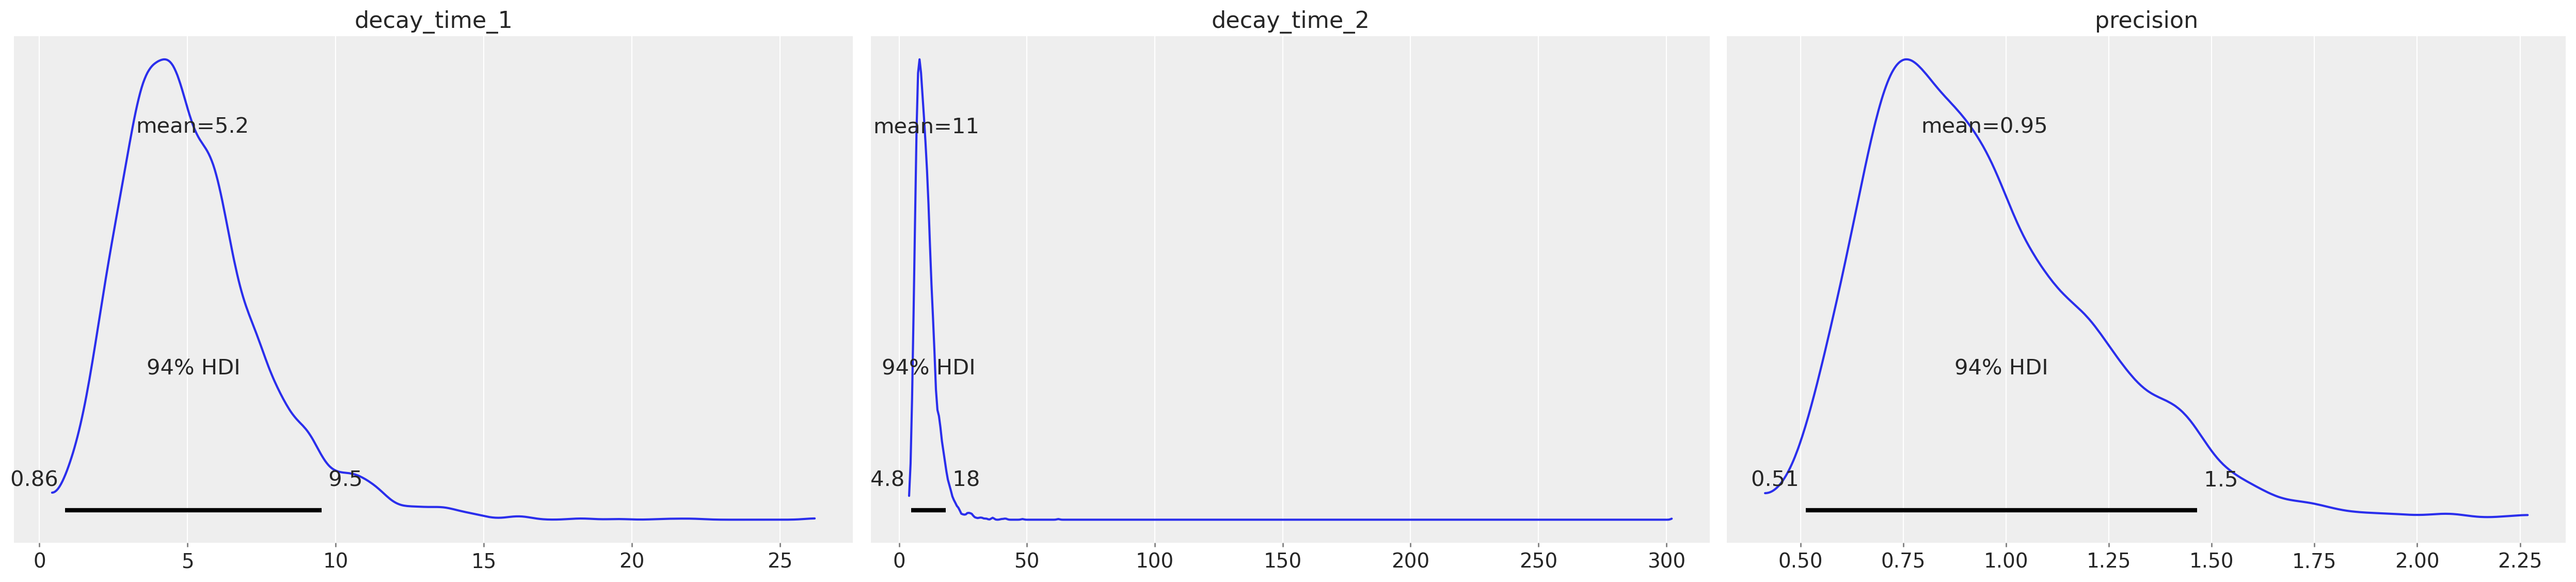

In [33]:
plot_posterior(trace_multi_model_7h, n_time_scale = 2)

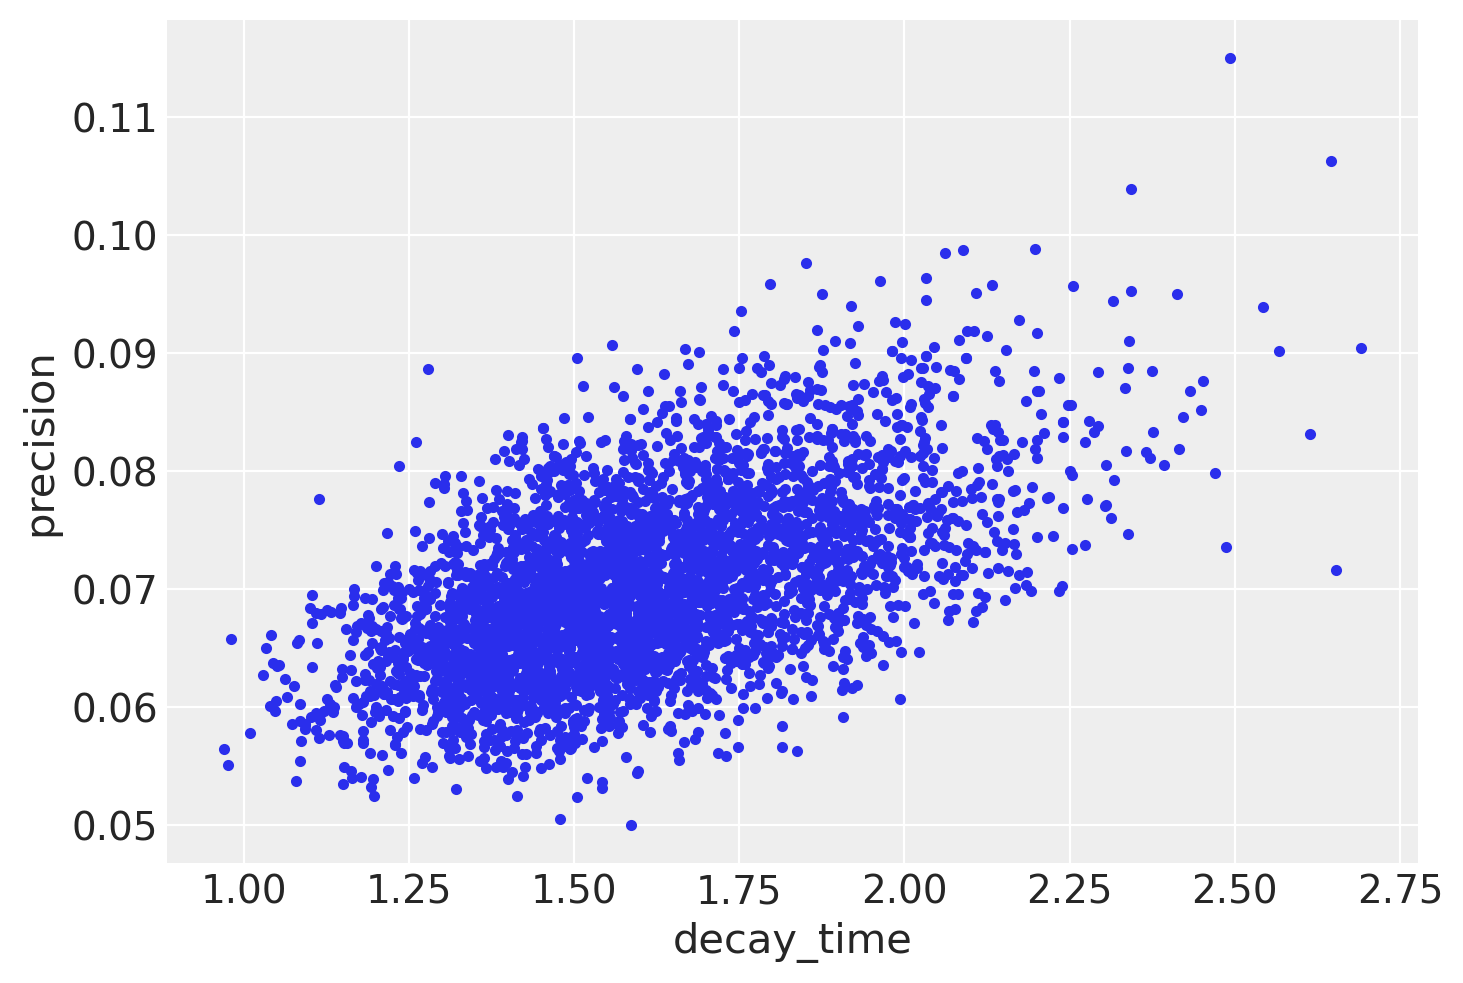

In [34]:
plot_pair(trace_multi_model_7h, n_time_scale = 2)

### Infer 24 hour aged sample

In [51]:
ar1_multi_model_24h=set_single_precision_model(data_24h['Intensity'], quantization)
trace_multi_model_24h = run_model(ar1_multi_model_24h)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Finished [100%]: Average Loss = 3,677.6
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_2, y_1, precision, decay_time_split, decay_time_1]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 168 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


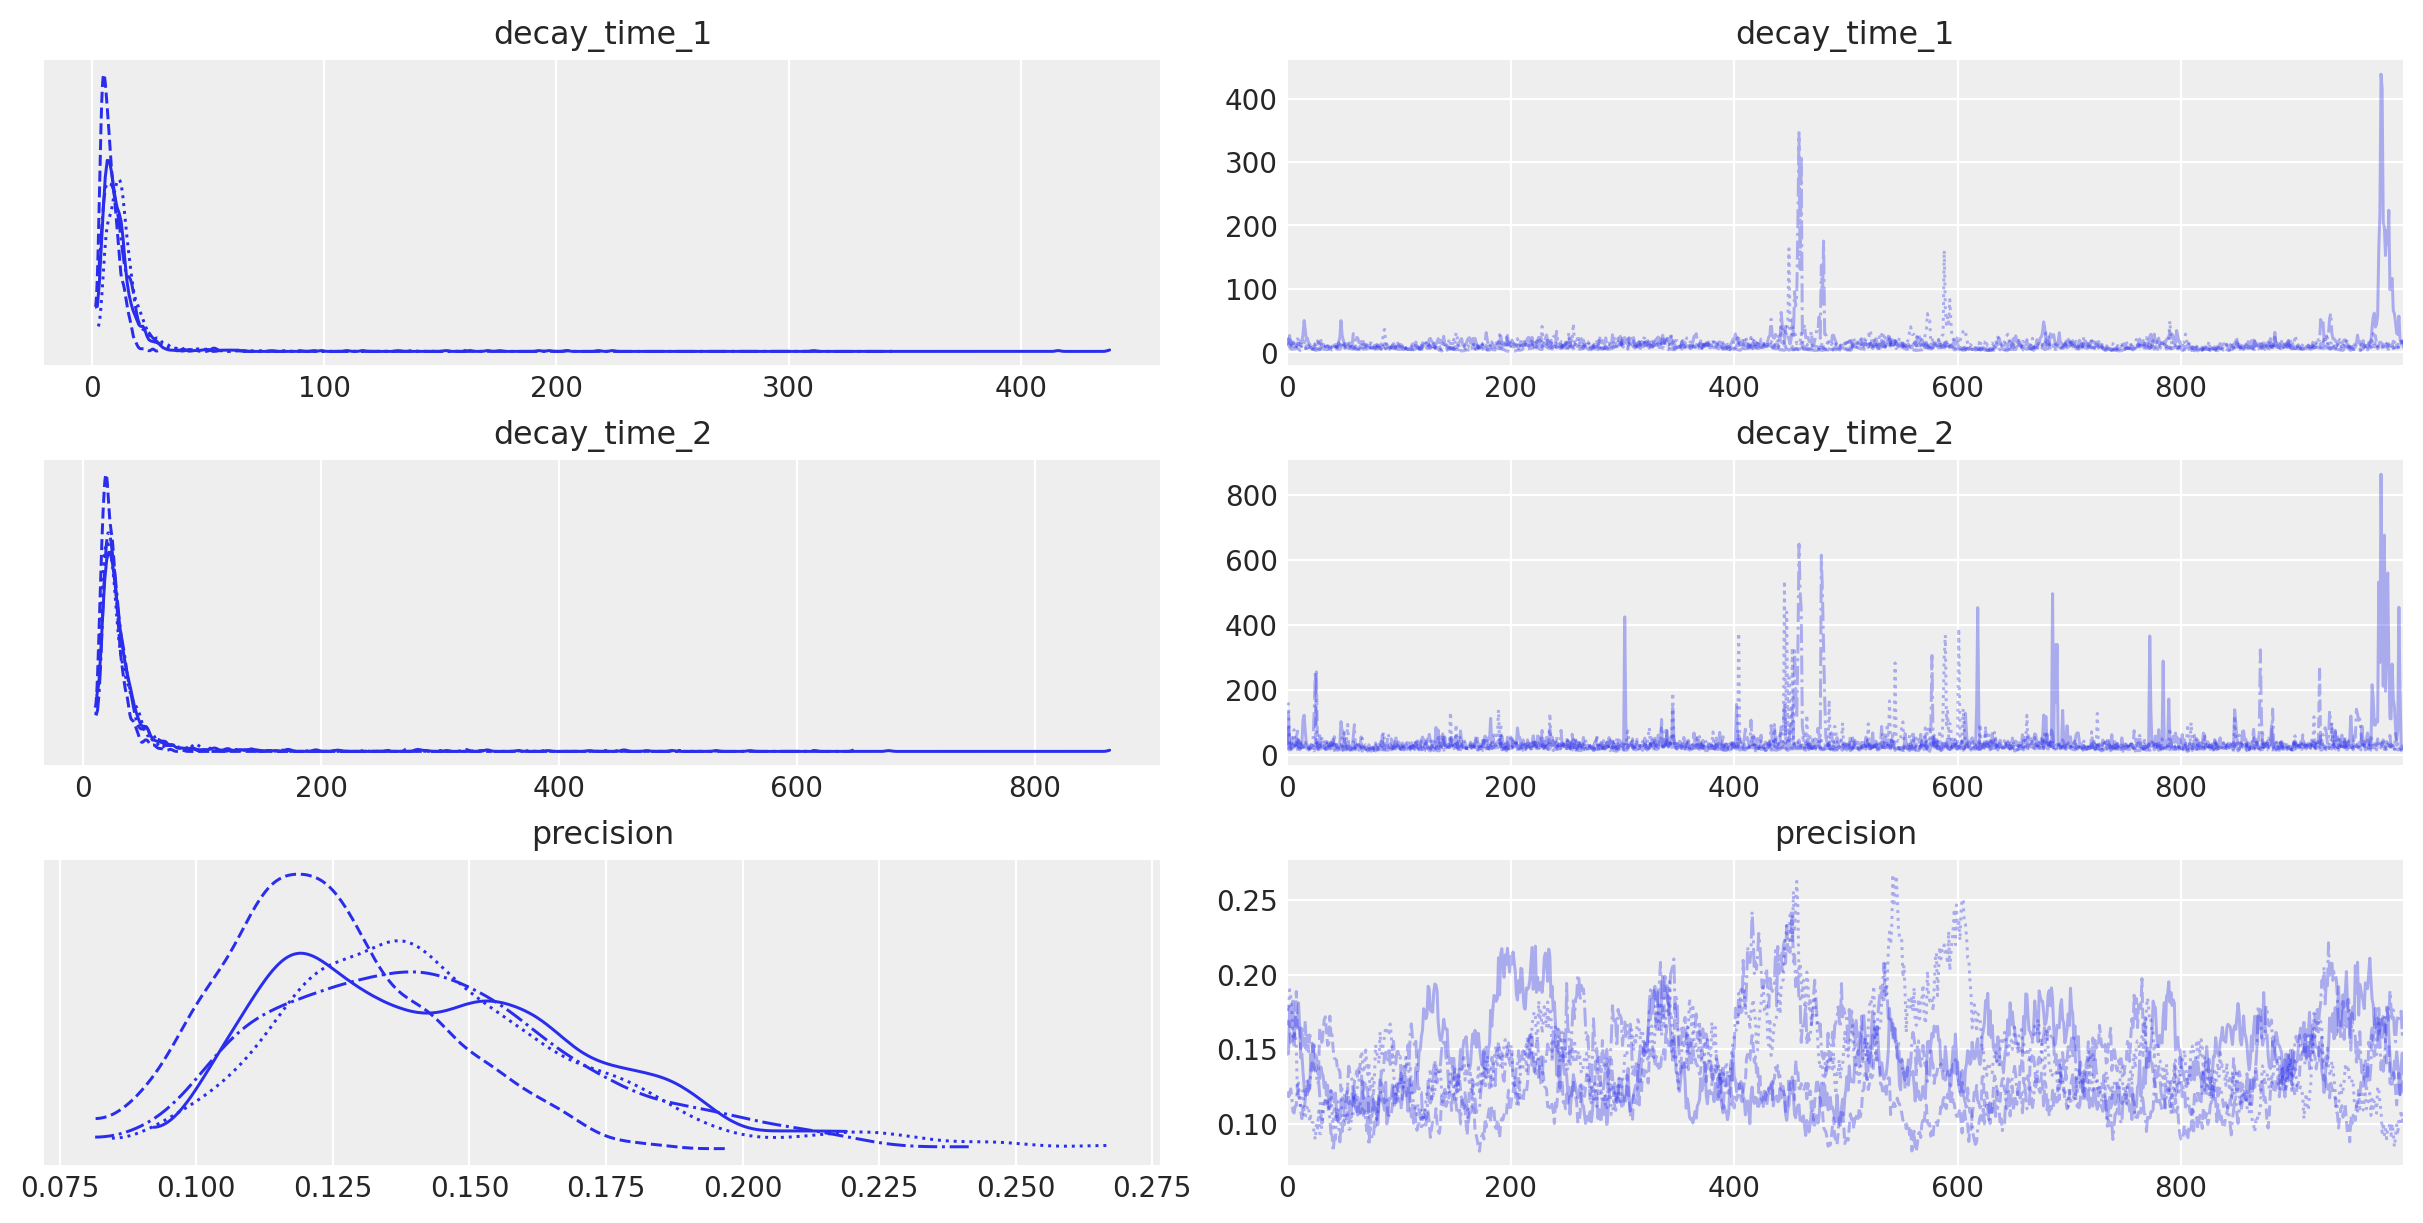

In [52]:
plot_trace(trace_multi_model_24h, n_time_scale = 2)

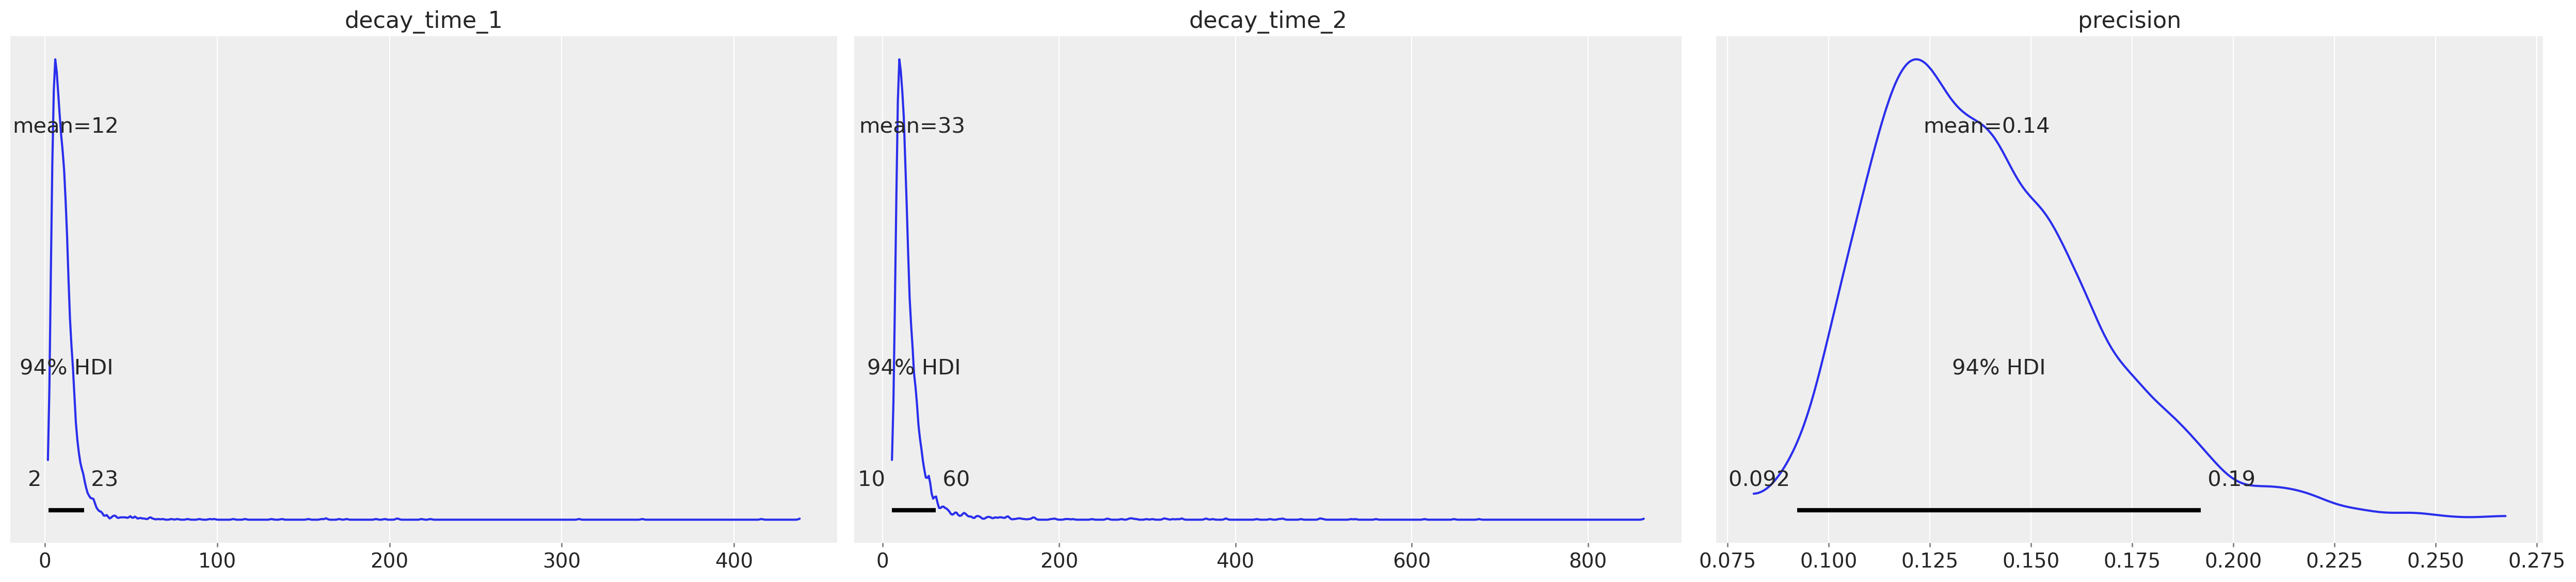

In [53]:
plot_posterior(trace_multi_model_24h, n_time_scale = 2)

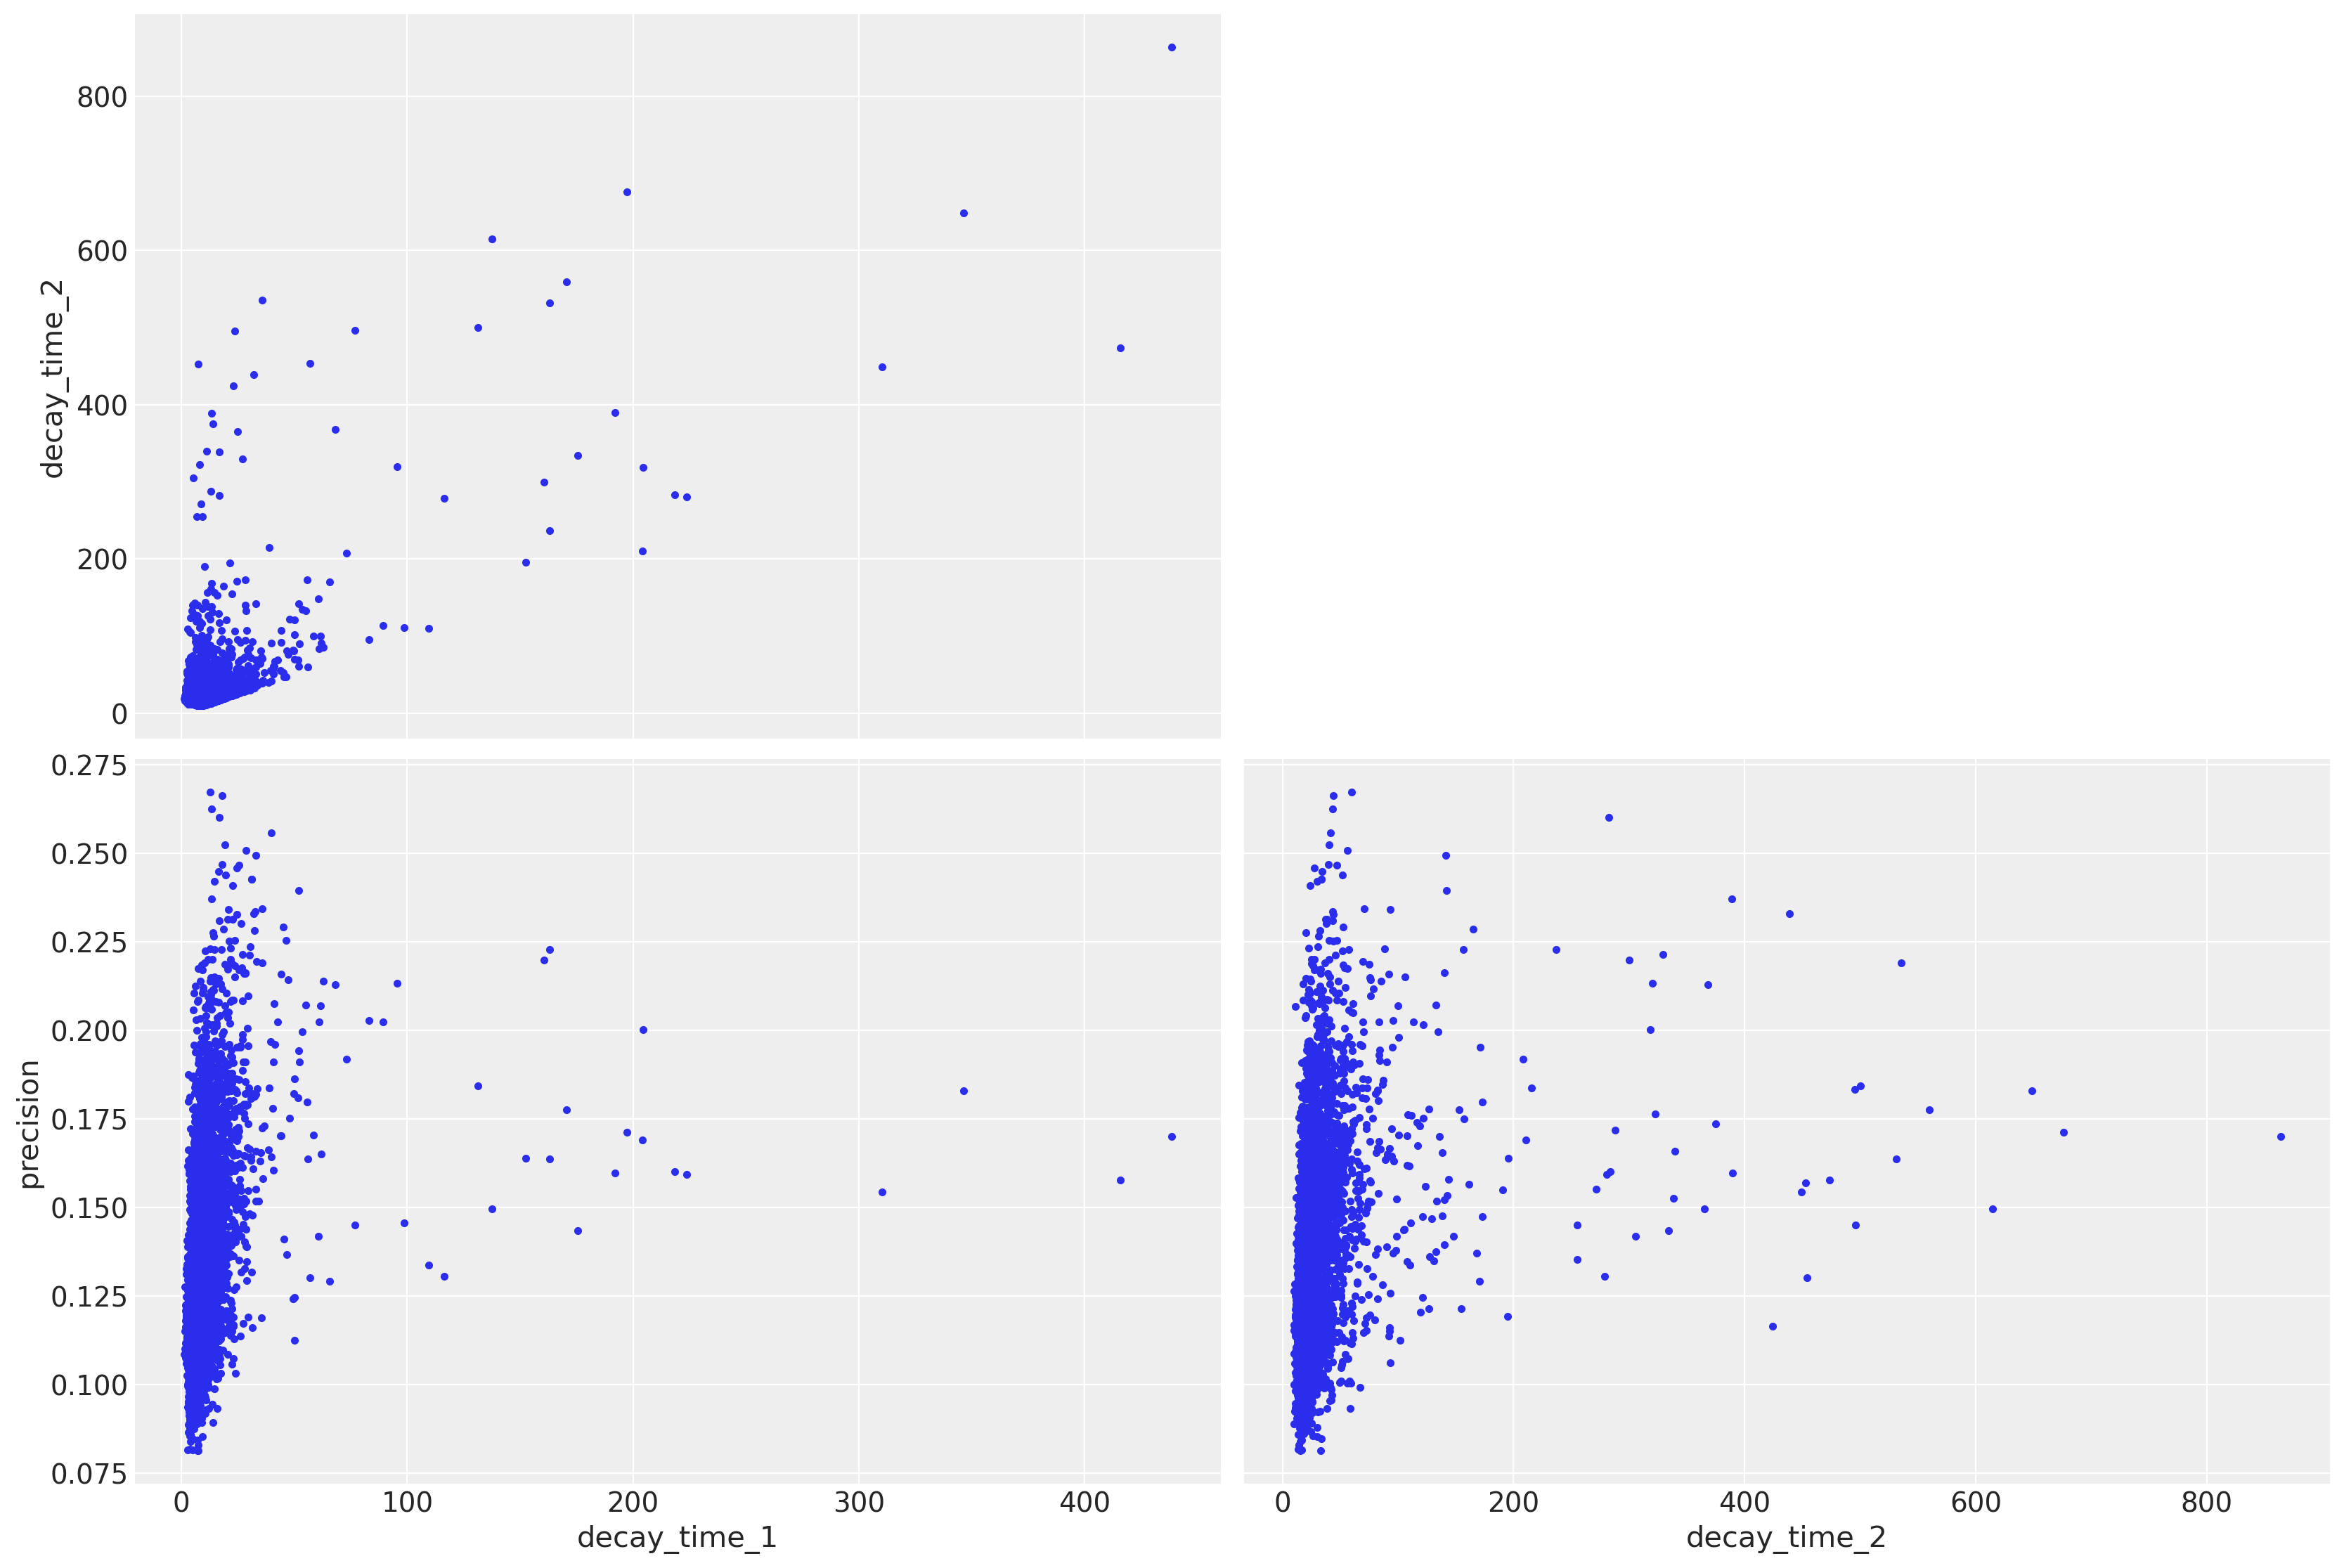

In [54]:
plot_pair(trace_multi_model_24h,n_time_scale = 2)